Attention Layer with Contrastive Learning

In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from data.utils import SimpleDataset, SimpleDataset_masked

from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN
from utils.trainer_helpers import batch_t_categorize, wt_avg, attention_mask


In [3]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch ESSA Training')
parser.add_argument('--dataset', default='SUPPORT', help='dataset setting')
parser.add_argument('-s',  default=16, type=int, help='embedding dimensions')
parser.add_argument('-nbin', default=100, type=int, help='discrete bins for time-to-event')

# parser.add_argument('--loss_type', default="MSE", type=str, help='point estimation loss type')
parser.add_argument('--loss_type',
                    default='MSE',
                    const='MSE',
                    nargs='?',
                    choices=['MSE', 'MAE', 'RAE'],
                    help='point estimation loss type (default: MSE)')

parser.add_argument('--percentile', default="False", type=str, help='time line discretize method')

parser.add_argument('-enc_dim', nargs='+', type=int, default=[32,32],
                    help='encoder structure')
parser.add_argument('-dec_dim', nargs='+', type=int, default=[32,32],
                    help='decoder structure')

parser.add_argument('--emb_lr', default=1e-4, type=float,
                    metavar='EMBLR', help='learning rate for embedding network')
parser.add_argument('--clf_lr', default=1e-4, type=float,
                    metavar='CLFLR', help='learning rate for contrastive network')
parser.add_argument('--dec_lr', default=1e-4, type=float,
                    metavar='DECLR', help='learning rate for decoding network')

parser.add_argument('--ct_wt', default=1, type=float, help='weight for contrastive loss')
parser.add_argument('--pt_wt', default=0, type=float, help='weight for point estimation loss')

parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--continue_training', default='False', type=str,
                    help='continue training on the last best epoch')
parser.add_argument('-batch_size', default=128, type=int,
                    metavar='N',
                    help='mini-batch size')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=2e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=100, type=int,
                    metavar='N', help='print frequency (default: 100)')

parser.add_argument('--result_path_root', '--wording-dir',default='', type=str, metavar='PATH',
                    help='path to the result files')
parser.add_argument('--file_path',default='', type=str, metavar='FILEPATH',
                    help='path to the data files')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')

parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--num_gpu', default=2, type=int,
                    help='number of GPU cores.')
parser.add_argument('--gpu', default=1, type=int,
                    help='GPU id to use.')

# to run argparse without command line
import sys
sys.argv = ['']

global args
args = parser.parse_args()


In [4]:
file_path='/data/zidi/cVAE/datasets/'
result_path_root = '/data/zidi/ACSurv/results/SUPPORT'

args.result_path_root = result_path_root
args.file_path = file_path
args.model_name = 'ESSA'

args.store_name = '_'.join([args.model_name, args.dataset, 'emb', str(args.s),\
                            'nbin', str(args.nbin),'perc', args.percentile,\
                            'enc', '_'.join([str(dim) for dim in args.enc_dim]),\
                            'dec', '_'.join([str(dim) for dim in args.dec_dim]),\
                           'ctWt', str(args.ct_wt), 'ptWt', str(args.pt_wt)])
args.store_name

'ESSA_SUPPORT_emb_16_nbin_100_perc_False_enc_32_32_dec_32_32_ctWt_1_ptWt_0'

## support Dataset

Load flchain dataset

In [5]:
from data.support_data import generate_data
file_path='/data/zidi/cVAE/datasets/'
result_path_root = '/data/zidi/ACSurv/results/SUPPORT'

train, valid, test, variable_info = generate_data(file_path = args.file_path, m=args.s)
train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

num_examples:7284
x_shape:(9105, 35)
end_time:2029
observed percent:0.6810543657331136
test:910, valid:911, train:7284, all: 9105
observed fold:0.6832784184514004
observed fold:0.6681318681318681
observed fold:0.6761800219538968


In [6]:
cov_list, cts_var, cts_idx, cat_var, cat_idx = variable_info['cov_list'], variable_info['cts_var'], variable_info['cts_idx'], variable_info['cat_var'], variable_info['cat_idx']

In [7]:
cov_list, cts_var, cat_var

(array(['age', 'sex', 'slos', 'dzgroup', 'dzclass', 'num_co', 'edu',
        'income', 'scoma', 'charges', 'totcst', 'avtisst', 'race', 'hday',
        'diabetes', 'dementia', 'ca', 'meanbp', 'wblc', 'hrt', 'resp',
        'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose',
        'bun', 'urine', 'adlp', 'adls', 'sfdm2', 'adlsc'], dtype='<U8'),
 array(['age', 'slos', 'num_co', 'edu', 'scoma', 'charges', 'totcst',
        'avtisst', 'hday', 'diabetes', 'dementia', 'meanbp', 'wblc', 'hrt',
        'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
        'glucose', 'bun', 'urine', 'adlp', 'adls', 'adlsc'], dtype='<U8'),
 array(['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'sfdm2'],
       dtype='<U8'))

In [8]:
x_landmarks, x_levels = variable_info['x_landmarks'], variable_info['x_levels']
x_landmarks, x_levels

(None, None)

In [10]:
train_time = train['t']

if bool(args.percentile):
    '''based on each covariate percentile'''
    t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,args.s))).contiguous()
    tt = np.percentile(train_time,np.linspace(0.,100.,args.nbin, endpoint=True))

else:
    '''based on the each covariate range'''
    t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),args.s, endpoint=True)).contiguous()
    tt = np.linspace(np.min(train_time),np.max(train_time),args.nbin, endpoint=True)


# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    args.nbin = args.nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)

t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
t_all_max, t_max, loss_of_info

(2029.0, 1944.0, 0.015650741350906095)

101

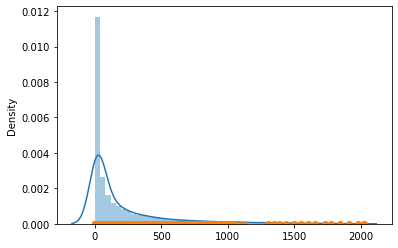

In [11]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')
len(tt)

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [12]:
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.ContrastiveLearning import FDV_CL
from model.SimpleNN import *



In [13]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset_masked(train['x'], train['t'], train['e'], train['missing_mask'])
pair1 = DataLoader(trainData, batch_size=args.batch_size,shuffle=True)

validData = SimpleDataset_masked(valid['x'], valid['t'], valid['e'], valid['missing_mask'])
v_pair1 = DataLoader(validData, batch_size=args.batch_size,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

testData = SimpleDataset_masked(test['x'], test['t'], test['e'], test['missing_mask'])
t_pair1 = DataLoader(testData, batch_size=args.batch_size,shuffle=True)


In [14]:
args.result_path_root

'/data/zidi/ACSurv/results/SUPPORT'

In [17]:
train

{'x': array([[49.89697  ,  0.       , 71.       , ...,  0.       ,  3.       ,
          0.       ],
        [48.008    ,  1.       , 16.       , ...,  1.       ,  2.       ,
          1.1667481],
        [59.63898  ,  1.       , 12.       , ...,  7.       ,  0.       ,
          7.       ],
        ...,
        [71.00098  ,  0.       , 16.       , ...,  6.       ,  0.       ,
          6.       ],
        [82.98999  ,  1.       , 12.       , ...,  0.       ,  4.       ,
          0.       ],
        [38.78198  ,  1.       ,  3.       , ...,  1.       , -1.       ,
          0.494751 ]]),
 't': array([308., 384.,  18., ...,  16., 220., 846.]),
 'e': array([1., 0., 1., ..., 1., 1., 0.]),
 'missing_mask': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 1]], dtype=int64)}

In [22]:
zdim = args.s
epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = args.gpu
n_gpu = args.num_gpu
all_device = set(np.arange(args.num_gpu))
all_device.remove(args.gpu)
device_ids = [args.gpu] + list(all_device)

torch.cuda.set_device(device_name)

# point estimation loss function and weight
# loss_type = args.loss_type
# lambda_ = args.pt_wt
# ctr_wt = args.ct_wt
# bined time
tt = torch.tensor(tt).to(device)

result_path = args.result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)
'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)

# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=args.emb_lr)
opt_dec = optim.Adam(decoder.parameters(), lr=args.dec_lr)
opt_clf = optim.Adam(clf.parameters(), lr=args.clf_lr)

# opt_emb = torch.optim.SGD(embedding.parameters(), args.emb_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# opt_dec = torch.optim.SGD(decoder.parameters(), args.dec_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# define scheduler
emb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_emb, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_dec, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
clf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_clf, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)


# opt_att = optim.Adam(attention.parameters(), lr=1e-4)

emb_path = result_path+args.store_name+'_emb'+'.pt'
dec_path = result_path+args.store_name+'_dec'+'.pt'
att_path = result_path+args.store_name+'_att'+'.pt'
clf_path = result_path+args.store_name+'_clf'+'.pt'

# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (age): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (slos): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (num_co): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (edu): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (scoma): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (charges): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (totcst): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (avtisst): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (hday): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (diabetes): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (dementia): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (meanbp): Paramet

epoch1


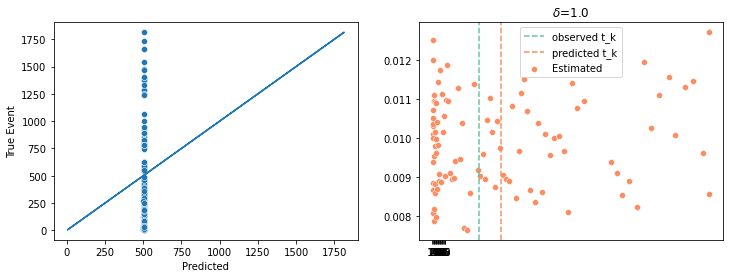

====> Train NLL: 3.697 	 Valid NLL: 3.666 CI: 0.526 event loss: 134925.354 	 censoring loss : 186136.960 	 Improved: *
epoch2


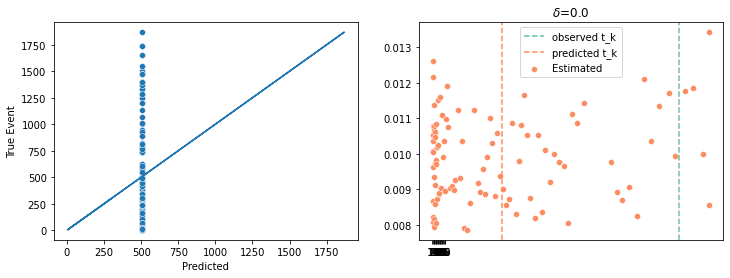

====> Train NLL: 3.689 	 Valid NLL: 3.660 CI: 0.575 event loss: 136616.556 	 censoring loss : 184579.730 	 Improved: *
epoch3


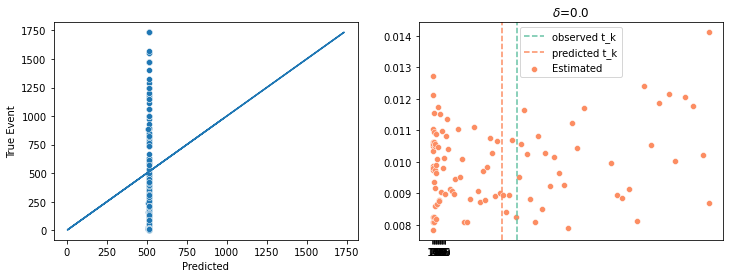

====> Train NLL: 3.683 	 Valid NLL: 3.653 CI: 0.577 event loss: 138525.231 	 censoring loss : 182837.118 	 Improved: *
epoch4


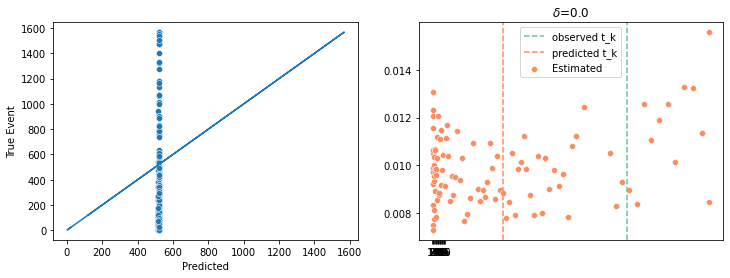

====> Train NLL: 3.676 	 Valid NLL: 3.643 CI: 0.584 event loss: 141515.421 	 censoring loss : 180101.131 	 Improved: *
epoch5
====> Train NLL: 3.665 	 Valid NLL: 3.627 CI: 0.582 event loss: 147519.379 	 censoring loss : 174939.395 	 Improved:  
epoch6
====> Train NLL: 3.648 	 Valid NLL: 3.603 CI: 0.577 event loss: 158607.965 	 censoring loss : 166190.685 	 Improved:  
epoch7
====> Train NLL: 3.625 	 Valid NLL: 3.574 CI: 0.572 event loss: 178547.036 	 censoring loss : 152486.364 	 Improved:  
epoch8
====> Train NLL: 3.605 	 Valid NLL: 3.550 CI: 0.574 event loss: 199246.030 	 censoring loss : 140192.764 	 Improved:  
epoch9
====> Train NLL: 3.590 	 Valid NLL: 3.532 CI: 0.582 event loss: 212033.611 	 censoring loss : 133082.348 	 Improved:  
epoch10


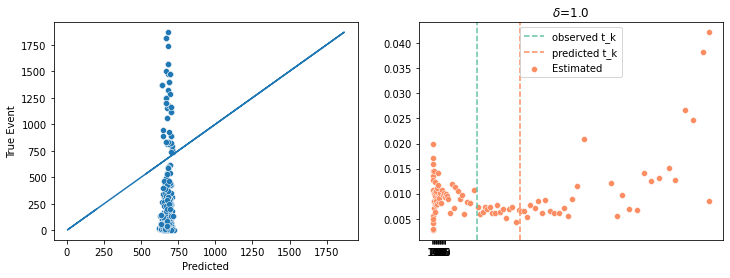

====> Train NLL: 3.575 	 Valid NLL: 3.518 CI: 0.590 event loss: 219496.670 	 censoring loss : 128794.090 	 Improved: *
epoch11


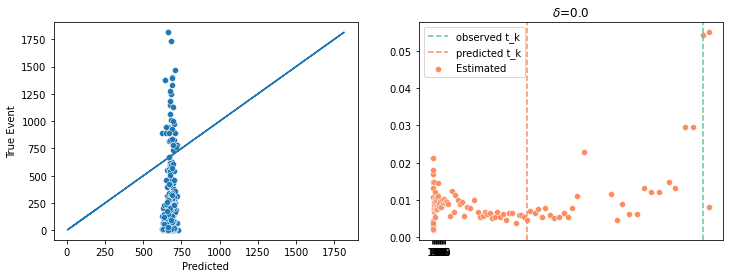

====> Train NLL: 3.566 	 Valid NLL: 3.507 CI: 0.596 event loss: 219904.412 	 censoring loss : 128044.737 	 Improved: *
epoch12


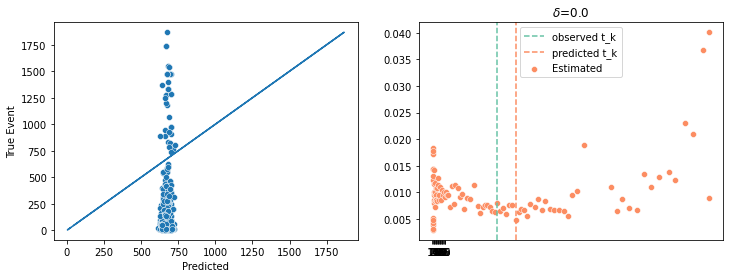

====> Train NLL: 3.562 	 Valid NLL: 3.500 CI: 0.599 event loss: 217761.806 	 censoring loss : 128680.280 	 Improved: *
epoch13


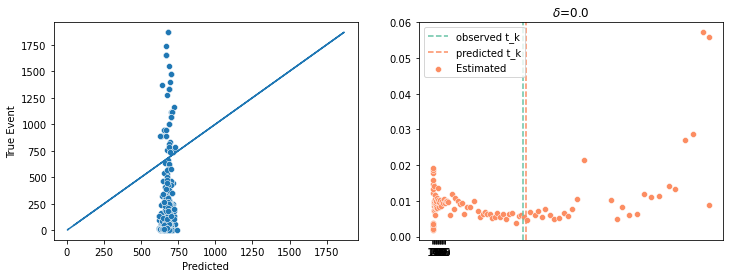

====> Train NLL: 3.550 	 Valid NLL: 3.492 CI: 0.600 event loss: 221759.331 	 censoring loss : 126397.938 	 Improved: *
epoch14


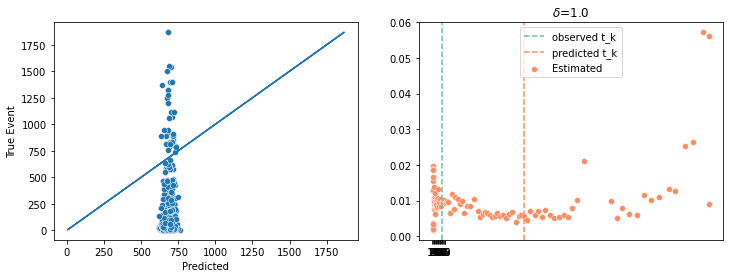

====> Train NLL: 3.547 	 Valid NLL: 3.484 CI: 0.600 event loss: 224979.556 	 censoring loss : 124270.649 	 Improved: *
epoch15


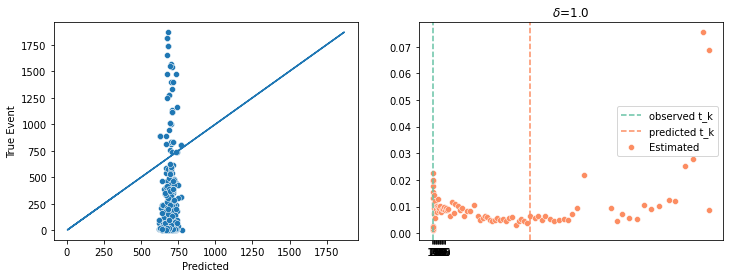

====> Train NLL: 3.536 	 Valid NLL: 3.476 CI: 0.603 event loss: 227997.916 	 censoring loss : 122003.655 	 Improved: *
epoch16


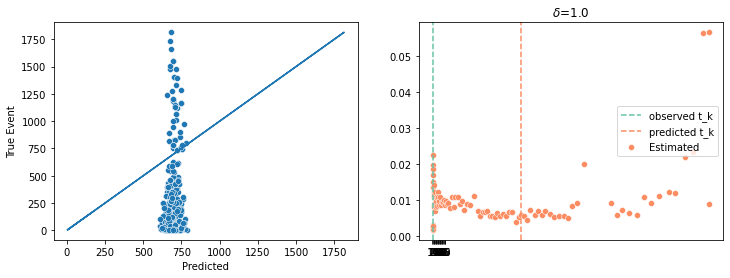

====> Train NLL: 3.524 	 Valid NLL: 3.470 CI: 0.612 event loss: 230060.386 	 censoring loss : 119969.115 	 Improved: *
epoch17


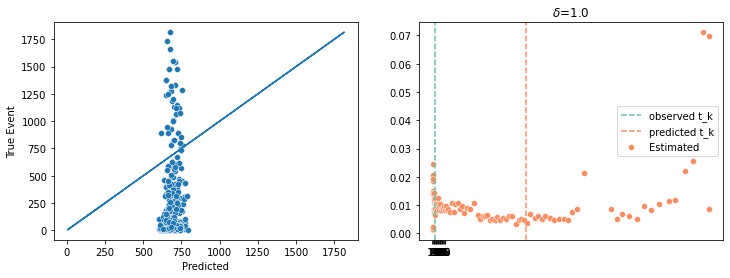

====> Train NLL: 3.527 	 Valid NLL: 3.464 CI: 0.620 event loss: 226858.469 	 censoring loss : 120211.450 	 Improved: *
epoch18


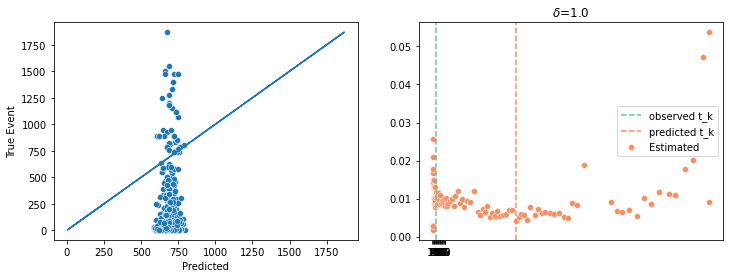

====> Train NLL: 3.515 	 Valid NLL: 3.457 CI: 0.633 event loss: 222353.320 	 censoring loss : 120512.282 	 Improved: *
epoch19


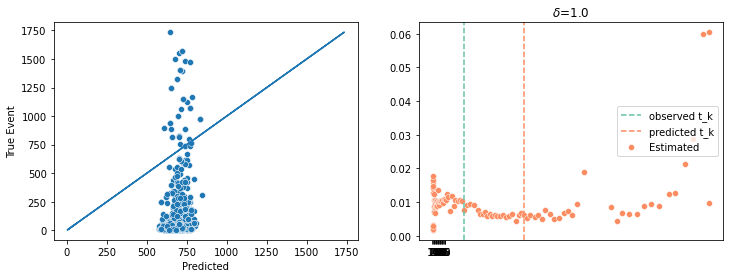

====> Train NLL: 3.506 	 Valid NLL: 3.447 CI: 0.651 event loss: 224716.866 	 censoring loss : 116218.121 	 Improved: *
epoch20


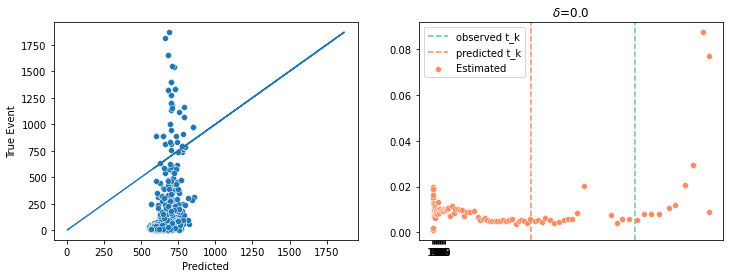

====> Train NLL: 3.499 	 Valid NLL: 3.439 CI: 0.674 event loss: 217007.848 	 censoring loss : 116002.748 	 Improved: *
epoch21


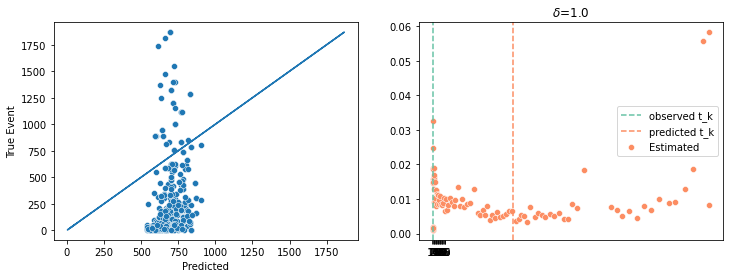

====> Train NLL: 3.486 	 Valid NLL: 3.425 CI: 0.691 event loss: 219065.008 	 censoring loss : 109615.962 	 Improved: *
epoch22


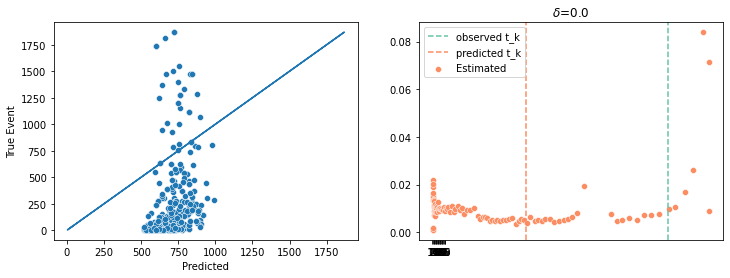

====> Train NLL: 3.463 	 Valid NLL: 3.405 CI: 0.709 event loss: 222074.793 	 censoring loss : 101454.841 	 Improved: *
epoch23


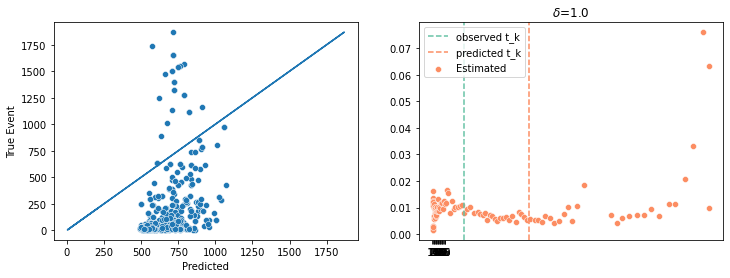

====> Train NLL: 3.447 	 Valid NLL: 3.384 CI: 0.726 event loss: 214120.109 	 censoring loss : 99336.474 	 Improved: *
epoch24


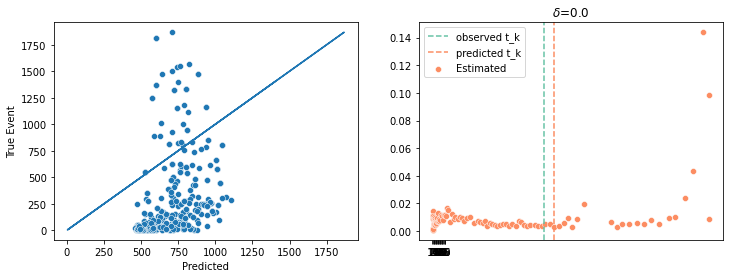

====> Train NLL: 3.426 	 Valid NLL: 3.359 CI: 0.741 event loss: 207088.445 	 censoring loss : 97068.647 	 Improved: *
epoch25


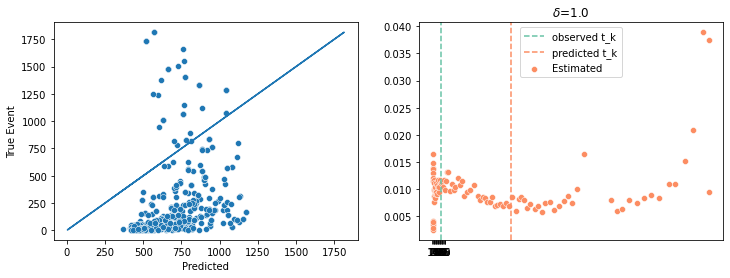

====> Train NLL: 3.394 	 Valid NLL: 3.325 CI: 0.752 event loss: 208744.418 	 censoring loss : 90633.208 	 Improved: *
epoch26


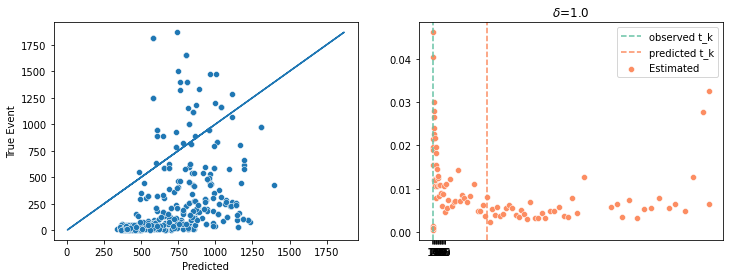

====> Train NLL: 3.360 	 Valid NLL: 3.287 CI: 0.762 event loss: 210741.335 	 censoring loss : 83843.029 	 Improved: *
epoch27


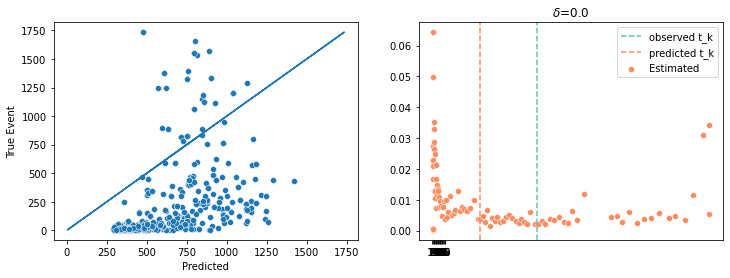

====> Train NLL: 3.327 	 Valid NLL: 3.250 CI: 0.770 event loss: 196967.211 	 censoring loss : 84791.842 	 Improved: *
epoch28


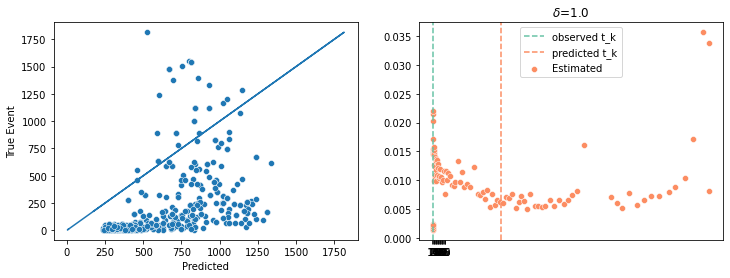

====> Train NLL: 3.294 	 Valid NLL: 3.206 CI: 0.780 event loss: 189847.756 	 censoring loss : 82272.410 	 Improved: *
epoch29


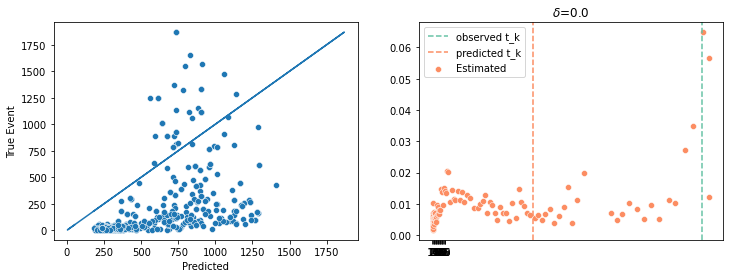

====> Train NLL: 3.257 	 Valid NLL: 3.167 CI: 0.788 event loss: 175934.631 	 censoring loss : 84097.314 	 Improved: *
epoch30


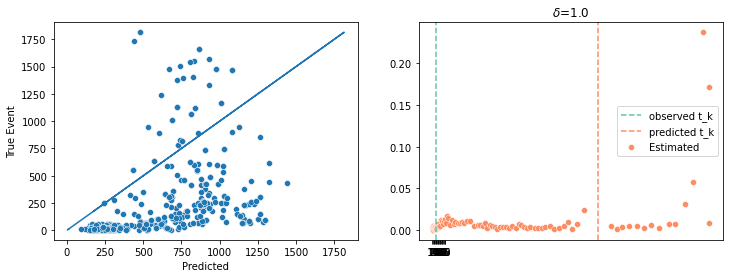

====> Train NLL: 3.221 	 Valid NLL: 3.127 CI: 0.794 event loss: 167512.416 	 censoring loss : 83205.305 	 Improved: *
epoch31


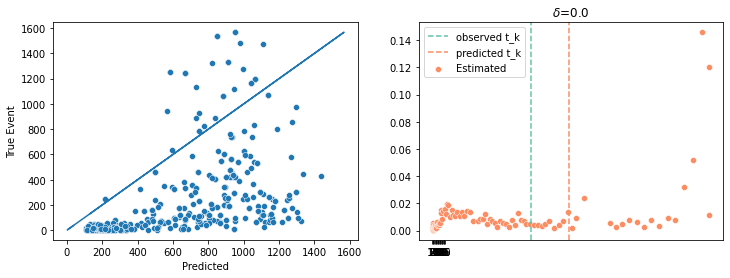

====> Train NLL: 3.175 	 Valid NLL: 3.086 CI: 0.798 event loss: 170383.275 	 censoring loss : 78610.350 	 Improved: *
epoch32


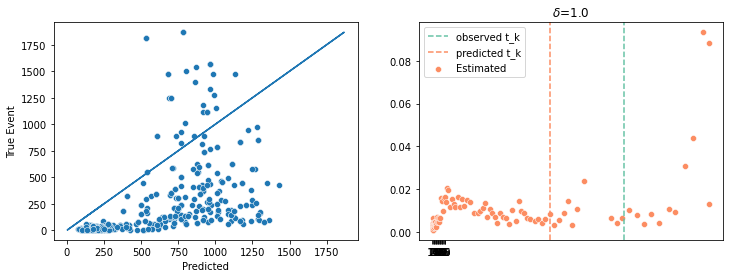

====> Train NLL: 3.147 	 Valid NLL: 3.046 CI: 0.806 event loss: 170898.520 	 censoring loss : 73236.474 	 Improved: *
epoch33


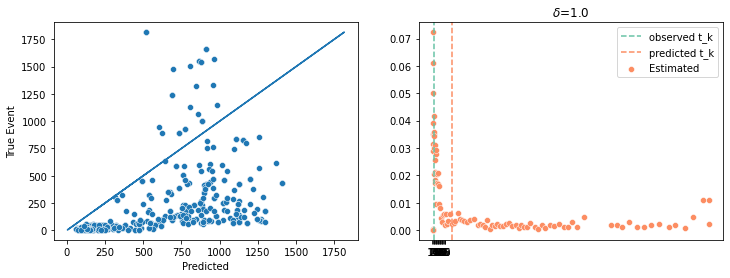

====> Train NLL: 3.118 	 Valid NLL: 3.016 CI: 0.809 event loss: 161105.432 	 censoring loss : 74270.186 	 Improved: *
epoch34


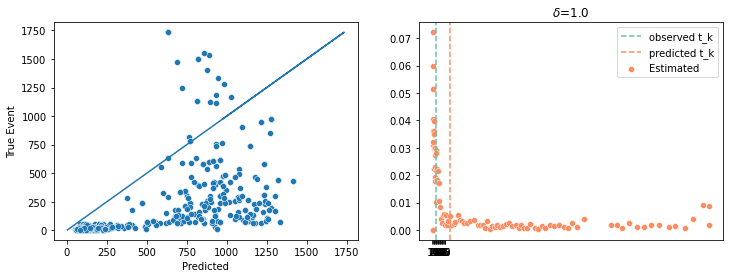

====> Train NLL: 3.091 	 Valid NLL: 2.985 CI: 0.812 event loss: 163067.569 	 censoring loss : 71228.201 	 Improved: *
epoch35


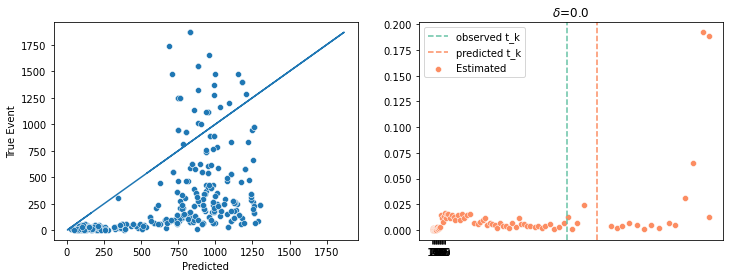

====> Train NLL: 3.071 	 Valid NLL: 2.957 CI: 0.815 event loss: 173090.620 	 censoring loss : 62884.677 	 Improved: *
epoch36


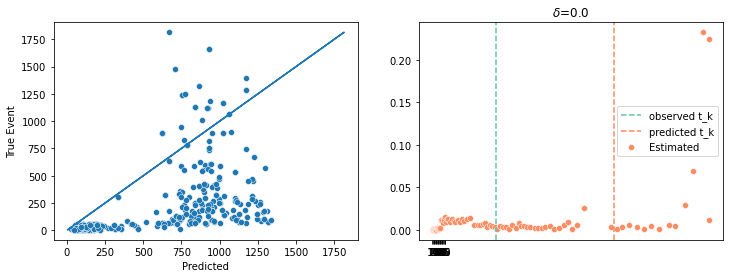

====> Train NLL: 3.066 	 Valid NLL: 2.940 CI: 0.816 event loss: 165129.328 	 censoring loss : 64998.850 	 Improved: *
epoch37


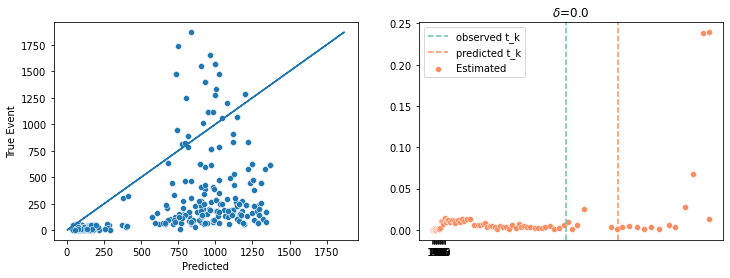

====> Train NLL: 3.035 	 Valid NLL: 2.917 CI: 0.820 event loss: 173365.001 	 censoring loss : 59484.058 	 Improved: *
epoch38


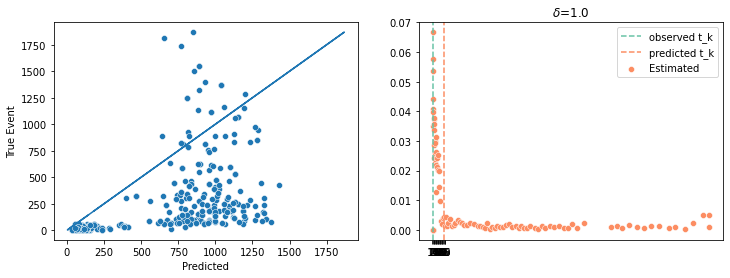

====> Train NLL: 3.023 	 Valid NLL: 2.901 CI: 0.822 event loss: 175080.714 	 censoring loss : 57068.488 	 Improved: *
epoch39


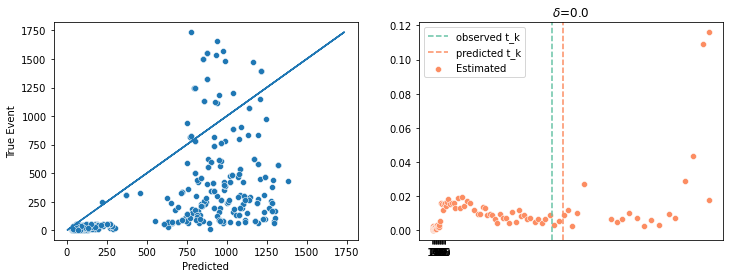

====> Train NLL: 3.009 	 Valid NLL: 2.892 CI: 0.822 event loss: 167054.887 	 censoring loss : 59702.593 	 Improved: *
epoch40


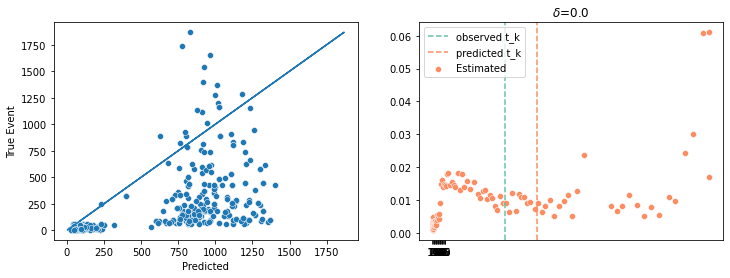

====> Train NLL: 2.995 	 Valid NLL: 2.878 CI: 0.824 event loss: 166573.621 	 censoring loss : 58786.976 	 Improved: *
epoch41


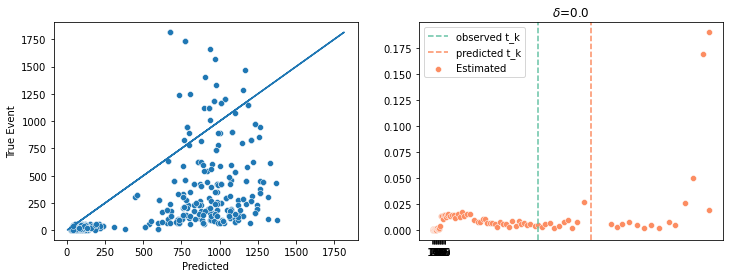

====> Train NLL: 2.987 	 Valid NLL: 2.873 CI: 0.824 event loss: 163513.899 	 censoring loss : 59335.012 	 Improved: *
epoch42


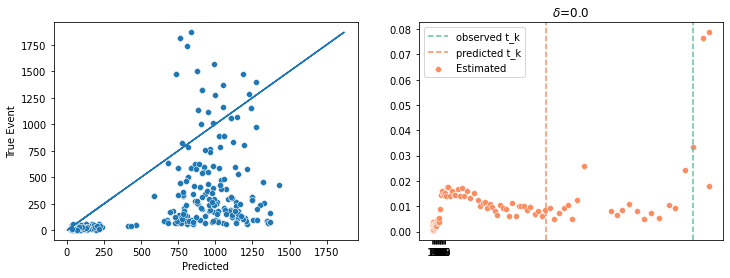

====> Train NLL: 2.982 	 Valid NLL: 2.862 CI: 0.827 event loss: 178256.582 	 censoring loss : 53705.256 	 Improved: *
epoch43


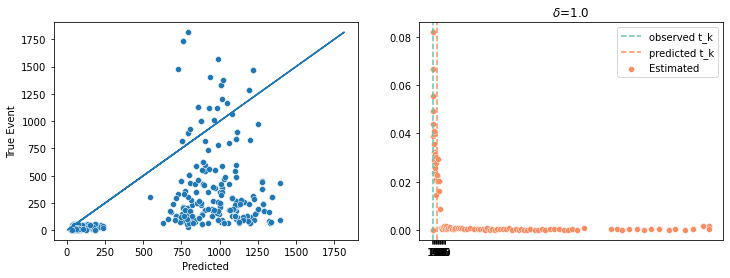

====> Train NLL: 2.986 	 Valid NLL: 2.860 CI: 0.826 event loss: 168834.869 	 censoring loss : 56499.522 	 Improved: *
epoch44


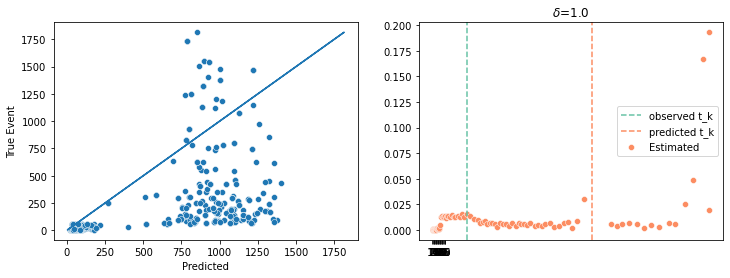

====> Train NLL: 2.967 	 Valid NLL: 2.851 CI: 0.827 event loss: 170198.616 	 censoring loss : 55035.316 	 Improved: *
epoch45


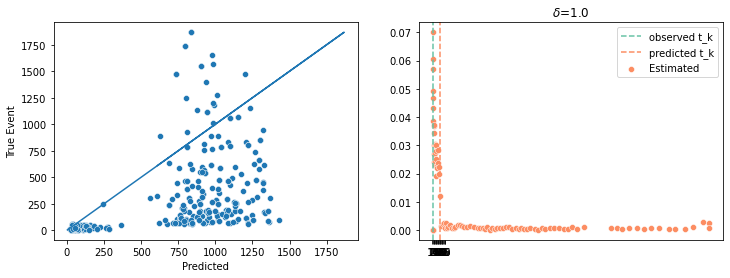

====> Train NLL: 2.966 	 Valid NLL: 2.845 CI: 0.829 event loss: 171589.117 	 censoring loss : 54119.241 	 Improved: *
epoch46


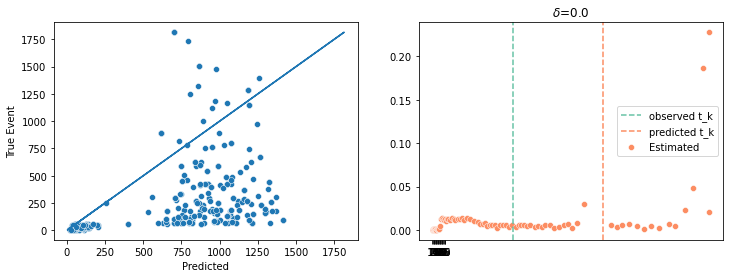

====> Train NLL: 2.960 	 Valid NLL: 2.845 CI: 0.829 event loss: 165464.031 	 censoring loss : 56733.053 	 Improved: *
epoch47


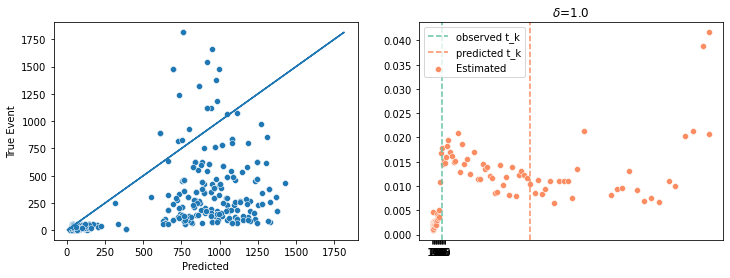

====> Train NLL: 2.958 	 Valid NLL: 2.841 CI: 0.827 event loss: 164169.361 	 censoring loss : 57259.841 	 Improved: *
epoch48


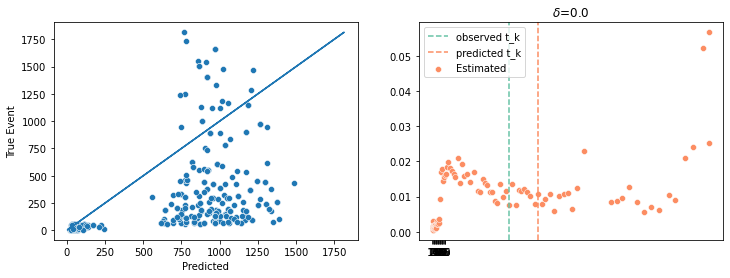

====> Train NLL: 2.951 	 Valid NLL: 2.835 CI: 0.830 event loss: 167349.336 	 censoring loss : 54911.165 	 Improved: *
epoch49


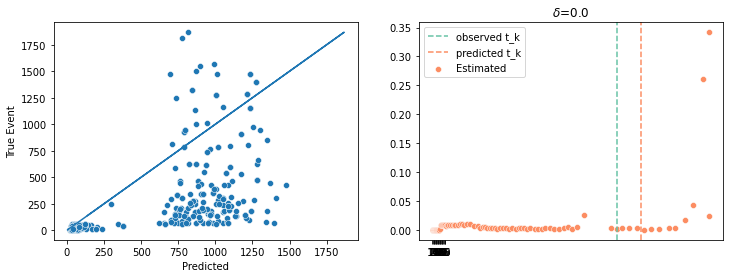

====> Train NLL: 2.950 	 Valid NLL: 2.832 CI: 0.831 event loss: 167129.071 	 censoring loss : 55174.567 	 Improved: *
epoch50


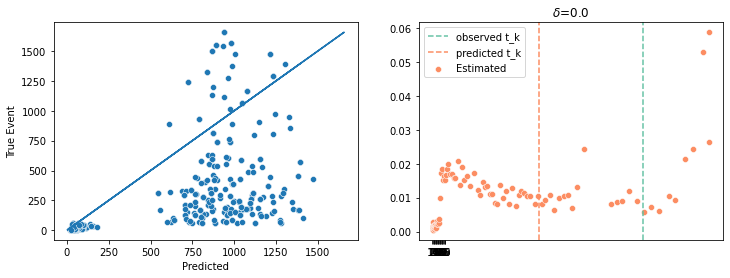

====> Train NLL: 2.950 	 Valid NLL: 2.829 CI: 0.831 event loss: 166729.174 	 censoring loss : 55398.310 	 Improved: *
epoch51


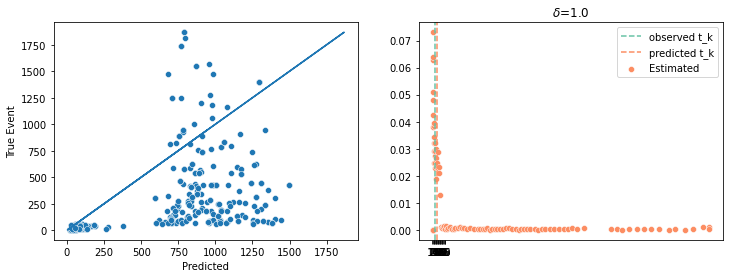

====> Train NLL: 2.940 	 Valid NLL: 2.828 CI: 0.832 event loss: 163443.084 	 censoring loss : 56674.475 	 Improved: *
epoch52


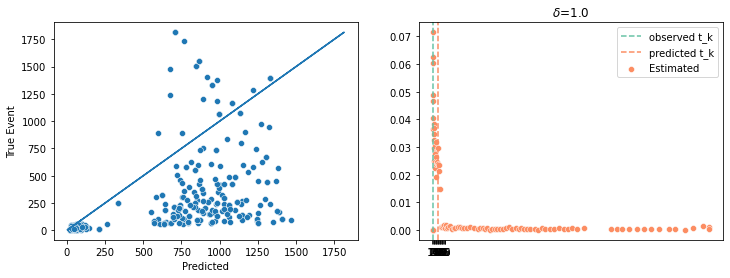

====> Train NLL: 2.934 	 Valid NLL: 2.822 CI: 0.834 event loss: 161253.872 	 censoring loss : 56321.196 	 Improved: *
epoch53
====> Train NLL: 2.939 	 Valid NLL: 2.818 CI: 0.833 event loss: 170681.314 	 censoring loss : 53538.711 	 Improved:  
epoch54


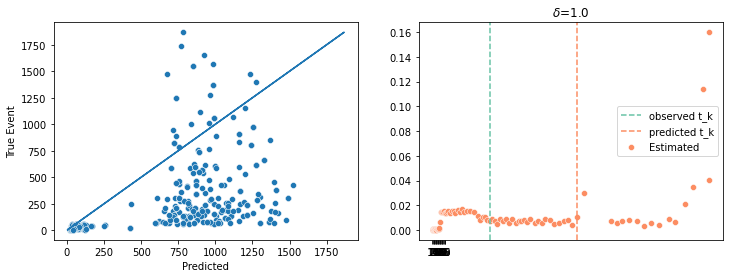

====> Train NLL: 2.927 	 Valid NLL: 2.816 CI: 0.835 event loss: 162580.511 	 censoring loss : 55890.923 	 Improved: *
epoch55
====> Train NLL: 2.927 	 Valid NLL: 2.811 CI: 0.834 event loss: 166081.761 	 censoring loss : 54891.768 	 Improved:  
epoch56


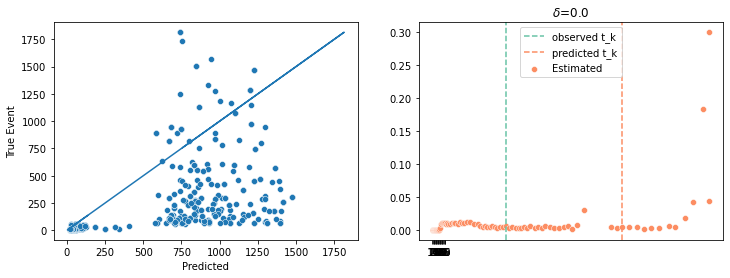

====> Train NLL: 2.927 	 Valid NLL: 2.812 CI: 0.836 event loss: 155447.265 	 censoring loss : 58263.639 	 Improved: *
epoch57


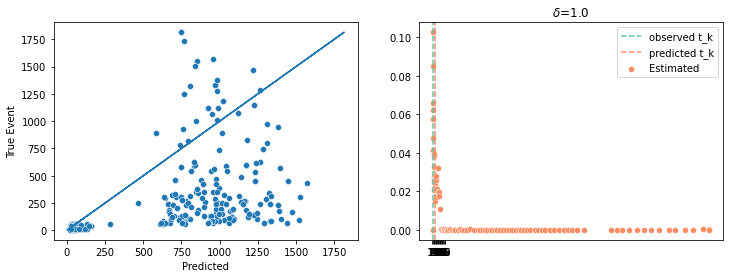

====> Train NLL: 2.925 	 Valid NLL: 2.807 CI: 0.837 event loss: 165860.831 	 censoring loss : 54073.501 	 Improved: *
epoch58


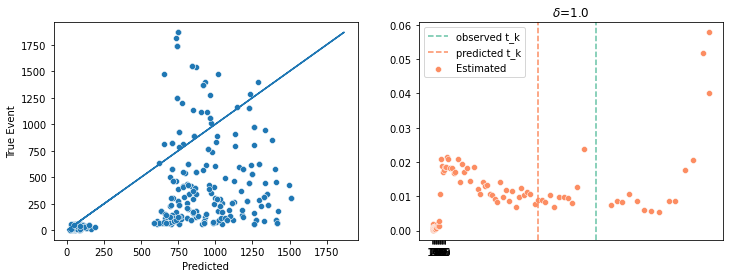

====> Train NLL: 2.930 	 Valid NLL: 2.804 CI: 0.839 event loss: 158319.098 	 censoring loss : 56347.764 	 Improved: *
epoch59
====> Train NLL: 2.921 	 Valid NLL: 2.800 CI: 0.839 event loss: 166796.468 	 censoring loss : 53774.730 	 Improved:  
epoch60
====> Train NLL: 2.914 	 Valid NLL: 2.799 CI: 0.839 event loss: 161831.905 	 censoring loss : 54958.873 	 Improved:  
epoch61


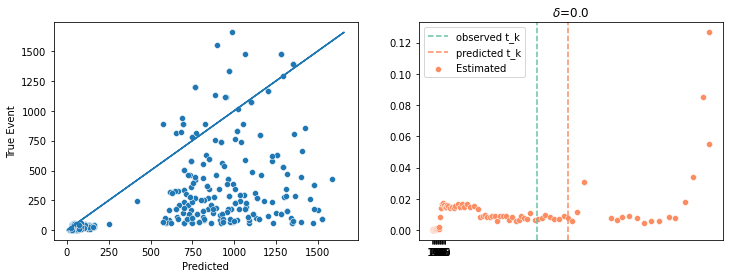

====> Train NLL: 2.912 	 Valid NLL: 2.795 CI: 0.840 event loss: 168880.152 	 censoring loss : 52406.567 	 Improved: *
epoch62


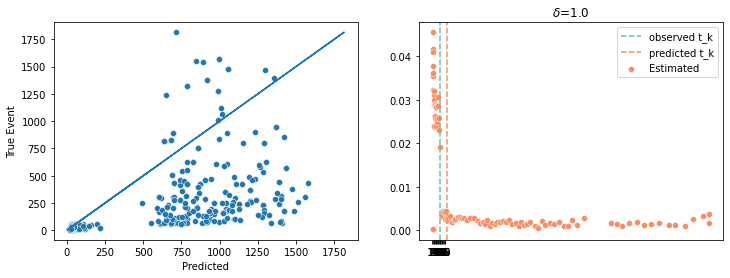

====> Train NLL: 2.902 	 Valid NLL: 2.791 CI: 0.841 event loss: 164830.696 	 censoring loss : 53533.881 	 Improved: *
epoch63


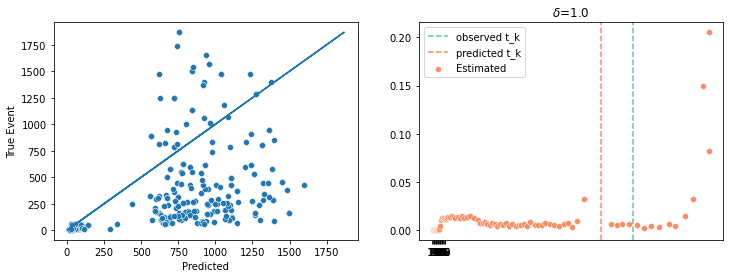

====> Train NLL: 2.910 	 Valid NLL: 2.792 CI: 0.841 event loss: 157976.983 	 censoring loss : 56284.033 	 Improved: *
epoch64


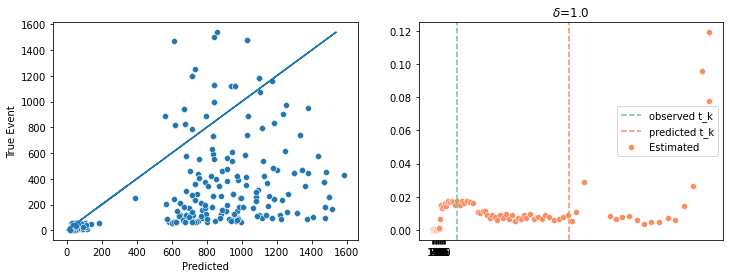

====> Train NLL: 2.902 	 Valid NLL: 2.787 CI: 0.842 event loss: 161219.008 	 censoring loss : 54313.280 	 Improved: *
epoch65
====> Train NLL: 2.901 	 Valid NLL: 2.783 CI: 0.842 event loss: 166337.612 	 censoring loss : 51913.421 	 Improved:  
epoch66


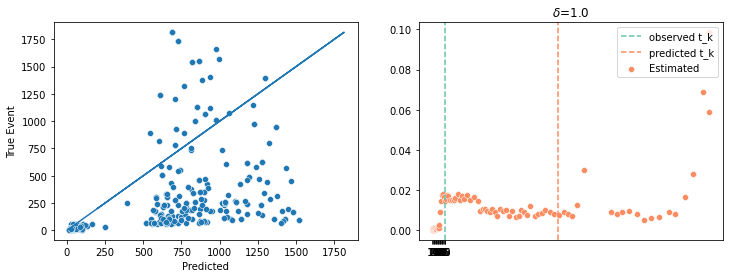

====> Train NLL: 2.898 	 Valid NLL: 2.783 CI: 0.843 event loss: 155182.653 	 censoring loss : 56430.692 	 Improved: *
epoch67


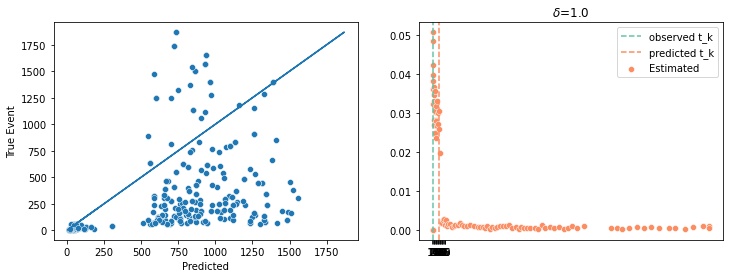

====> Train NLL: 2.902 	 Valid NLL: 2.782 CI: 0.843 event loss: 154697.491 	 censoring loss : 56109.479 	 Improved: *
epoch68
====> Train NLL: 2.886 	 Valid NLL: 2.776 CI: 0.843 event loss: 159268.743 	 censoring loss : 54164.769 	 Improved:  
epoch69


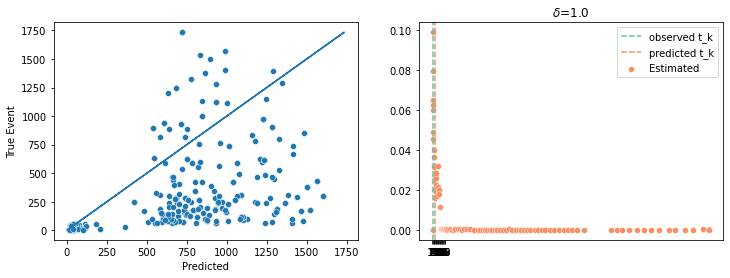

====> Train NLL: 2.882 	 Valid NLL: 2.773 CI: 0.845 event loss: 156712.341 	 censoring loss : 54723.505 	 Improved: *
epoch70


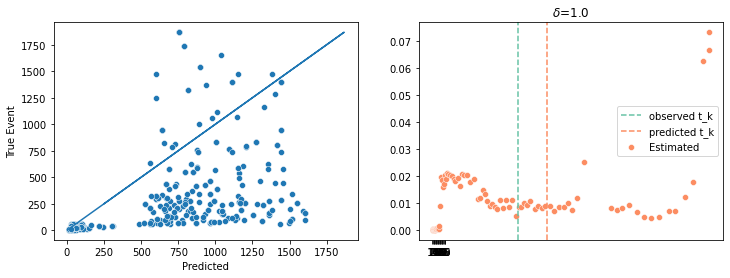

====> Train NLL: 2.889 	 Valid NLL: 2.769 CI: 0.846 event loss: 180077.287 	 censoring loss : 46583.821 	 Improved: *
epoch71


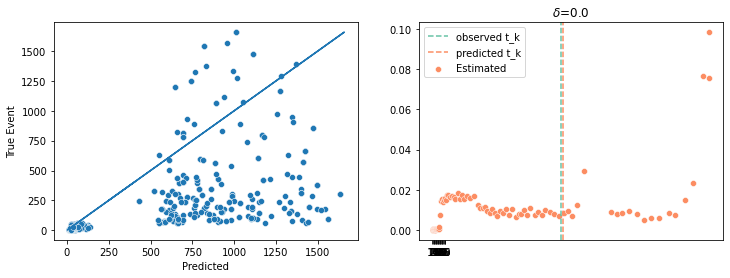

====> Train NLL: 2.890 	 Valid NLL: 2.766 CI: 0.847 event loss: 160175.002 	 censoring loss : 52794.820 	 Improved: *
epoch72
====> Train NLL: 2.871 	 Valid NLL: 2.768 CI: 0.846 event loss: 154065.730 	 censoring loss : 56182.736 	 Improved:  
epoch73


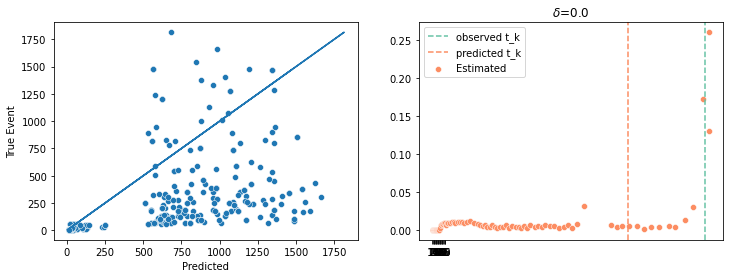

====> Train NLL: 2.871 	 Valid NLL: 2.760 CI: 0.848 event loss: 165877.067 	 censoring loss : 50693.383 	 Improved: *
epoch74


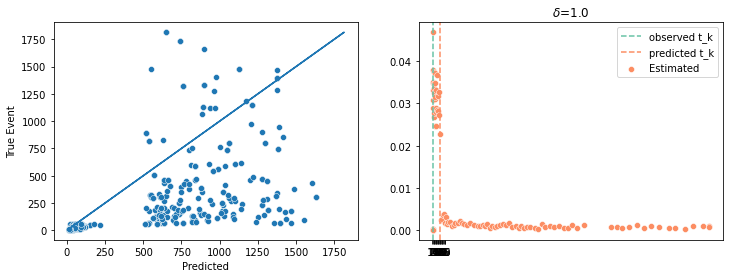

====> Train NLL: 2.872 	 Valid NLL: 2.759 CI: 0.848 event loss: 150676.680 	 censoring loss : 56105.681 	 Improved: *
epoch75


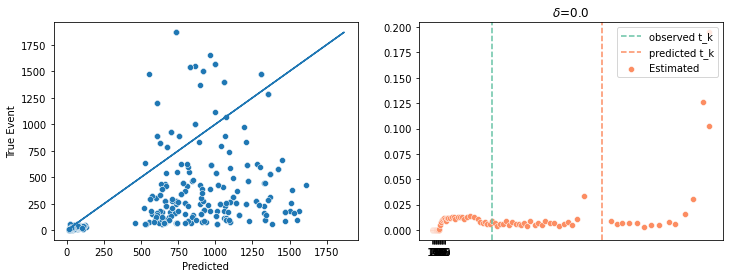

====> Train NLL: 2.862 	 Valid NLL: 2.753 CI: 0.849 event loss: 158058.670 	 censoring loss : 53464.563 	 Improved: *
epoch76


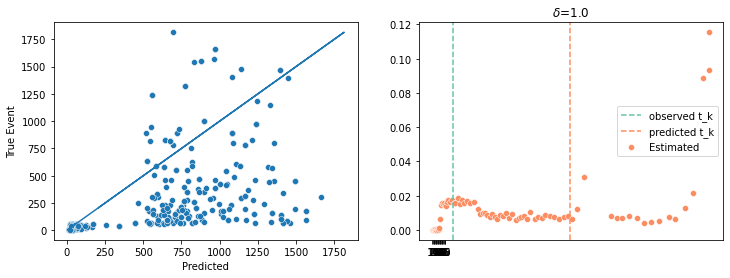

====> Train NLL: 2.878 	 Valid NLL: 2.751 CI: 0.849 event loss: 160216.387 	 censoring loss : 51148.120 	 Improved: *
epoch77
====> Train NLL: 2.864 	 Valid NLL: 2.748 CI: 0.848 event loss: 168044.888 	 censoring loss : 49114.494 	 Improved:  
epoch78


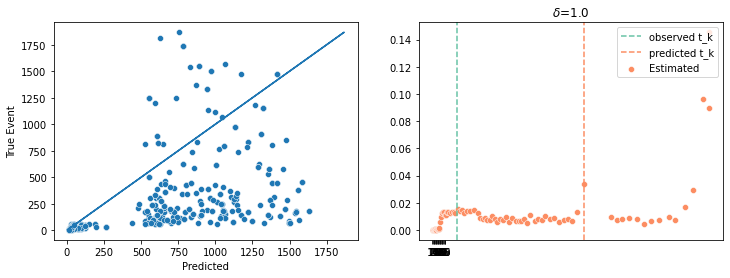

====> Train NLL: 2.855 	 Valid NLL: 2.742 CI: 0.851 event loss: 163264.802 	 censoring loss : 50284.728 	 Improved: *
epoch79
====> Train NLL: 2.856 	 Valid NLL: 2.742 CI: 0.850 event loss: 159304.286 	 censoring loss : 51997.773 	 Improved:  
epoch80


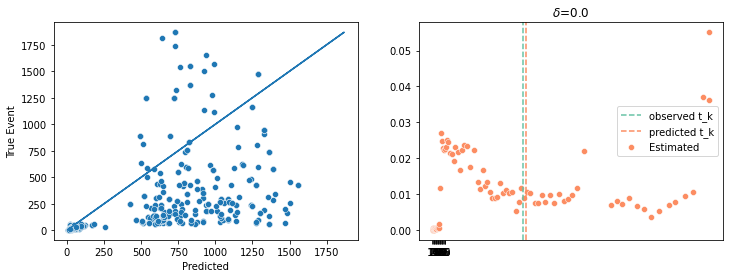

====> Train NLL: 2.853 	 Valid NLL: 2.741 CI: 0.852 event loss: 147622.759 	 censoring loss : 56828.621 	 Improved: *
epoch81
====> Train NLL: 2.854 	 Valid NLL: 2.737 CI: 0.851 event loss: 159803.090 	 censoring loss : 51908.302 	 Improved:  
epoch82
====> Train NLL: 2.854 	 Valid NLL: 2.733 CI: 0.852 event loss: 155202.055 	 censoring loss : 53194.313 	 Improved:  
epoch83


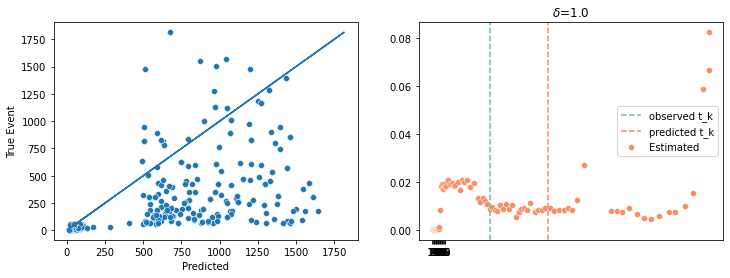

====> Train NLL: 2.851 	 Valid NLL: 2.734 CI: 0.853 event loss: 151839.677 	 censoring loss : 53854.360 	 Improved: *
epoch84
====> Train NLL: 2.853 	 Valid NLL: 2.731 CI: 0.852 event loss: 157701.339 	 censoring loss : 51759.064 	 Improved:  
epoch85


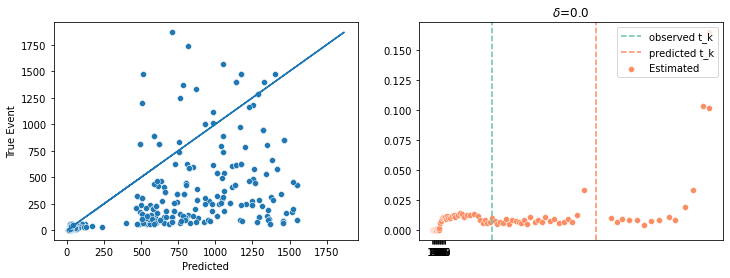

====> Train NLL: 2.845 	 Valid NLL: 2.726 CI: 0.854 event loss: 147229.436 	 censoring loss : 55018.422 	 Improved: *
epoch86
====> Train NLL: 2.838 	 Valid NLL: 2.723 CI: 0.853 event loss: 157607.483 	 censoring loss : 51805.166 	 Improved:  
epoch87
====> Train NLL: 2.836 	 Valid NLL: 2.717 CI: 0.853 event loss: 164819.527 	 censoring loss : 48786.716 	 Improved:  
epoch88


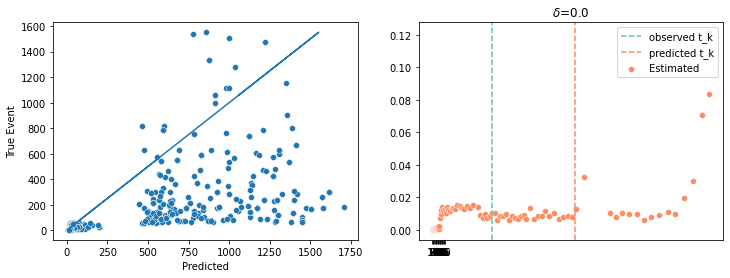

====> Train NLL: 2.834 	 Valid NLL: 2.717 CI: 0.854 event loss: 154068.317 	 censoring loss : 53163.435 	 Improved: *
epoch89


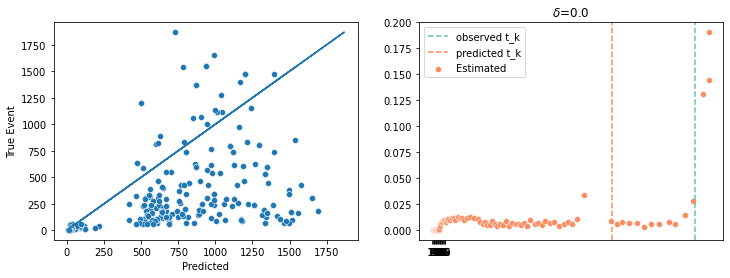

====> Train NLL: 2.822 	 Valid NLL: 2.711 CI: 0.855 event loss: 153101.810 	 censoring loss : 52434.018 	 Improved: *
epoch90


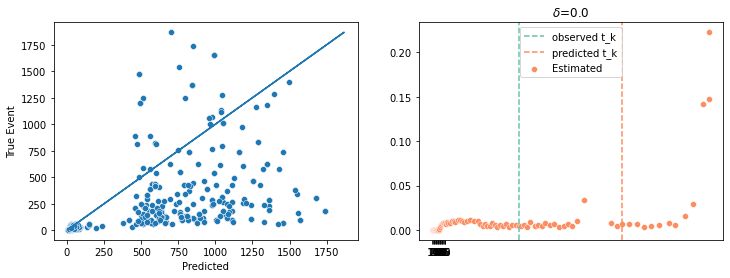

====> Train NLL: 2.833 	 Valid NLL: 2.710 CI: 0.855 event loss: 157835.147 	 censoring loss : 52036.569 	 Improved: *
epoch91
====> Train NLL: 2.822 	 Valid NLL: 2.704 CI: 0.855 event loss: 170519.720 	 censoring loss : 46395.462 	 Improved:  
epoch92


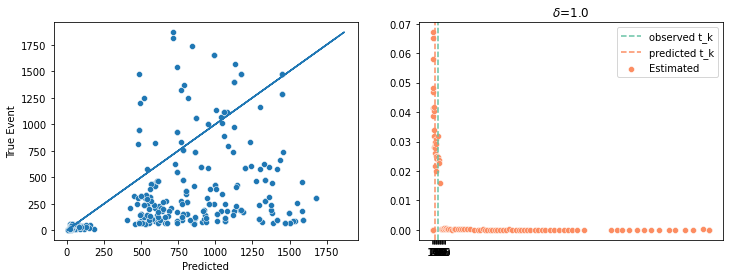

====> Train NLL: 2.815 	 Valid NLL: 2.700 CI: 0.855 event loss: 161000.267 	 censoring loss : 49577.862 	 Improved: *
epoch93
====> Train NLL: 2.816 	 Valid NLL: 2.701 CI: 0.855 event loss: 142495.782 	 censoring loss : 57291.715 	 Improved:  
epoch94


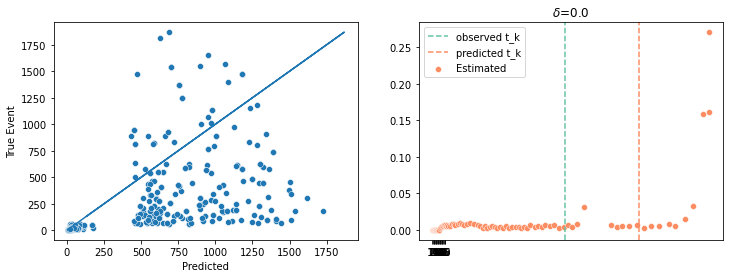

====> Train NLL: 2.816 	 Valid NLL: 2.696 CI: 0.856 event loss: 142732.263 	 censoring loss : 56978.118 	 Improved: *
epoch95


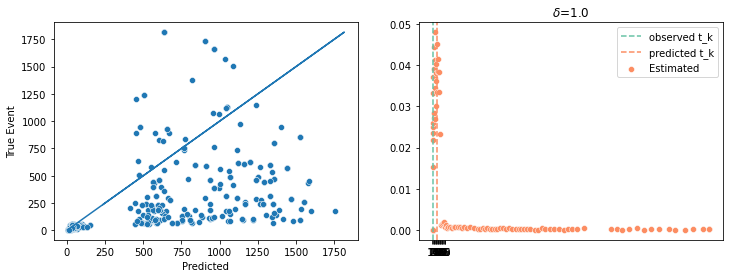

====> Train NLL: 2.809 	 Valid NLL: 2.689 CI: 0.857 event loss: 153398.413 	 censoring loss : 52482.013 	 Improved: *
epoch96


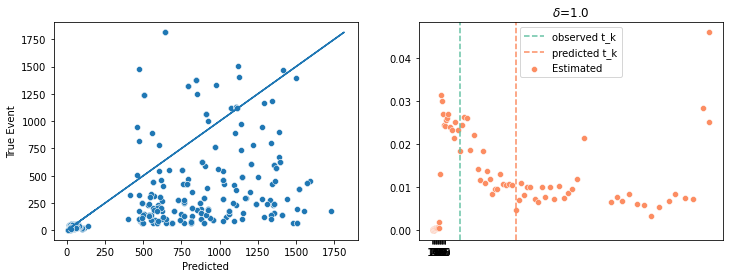

====> Train NLL: 2.810 	 Valid NLL: 2.686 CI: 0.857 event loss: 155282.653 	 censoring loss : 50378.010 	 Improved: *
epoch97


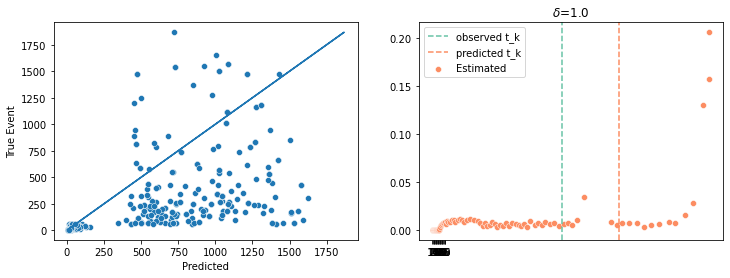

====> Train NLL: 2.798 	 Valid NLL: 2.685 CI: 0.855 event loss: 155252.405 	 censoring loss : 52466.770 	 Improved: *
epoch98


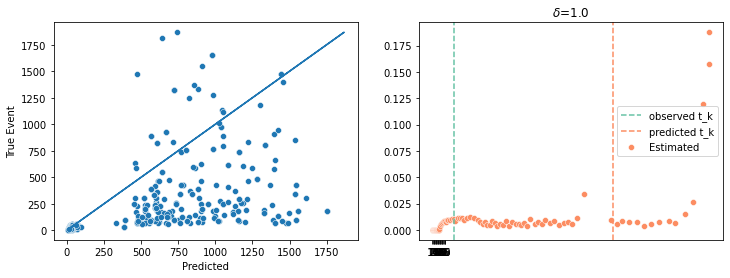

====> Train NLL: 2.803 	 Valid NLL: 2.680 CI: 0.857 event loss: 152853.466 	 censoring loss : 52543.985 	 Improved: *
epoch99
====> Train NLL: 2.797 	 Valid NLL: 2.679 CI: 0.857 event loss: 154411.655 	 censoring loss : 52164.670 	 Improved:  
epoch100


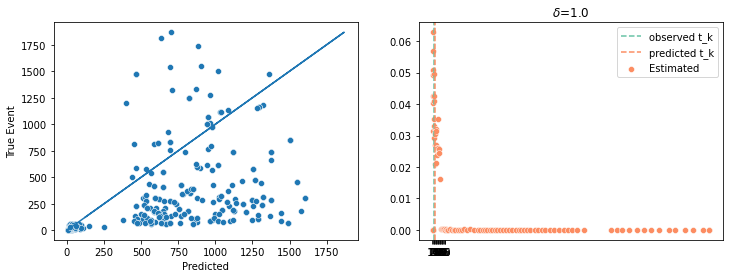

====> Train NLL: 2.797 	 Valid NLL: 2.680 CI: 0.856 event loss: 146882.549 	 censoring loss : 55112.243 	 Improved: *
epoch101


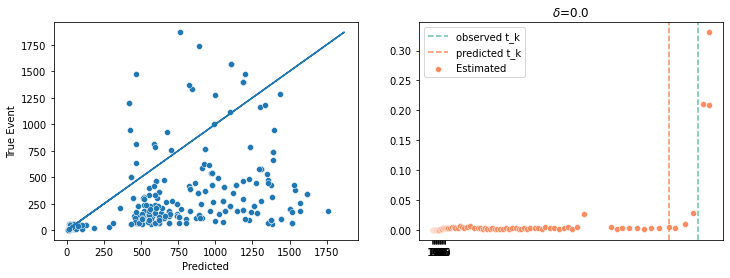

====> Train NLL: 2.789 	 Valid NLL: 2.674 CI: 0.858 event loss: 147641.468 	 censoring loss : 53539.438 	 Improved: *
epoch102
====> Train NLL: 2.781 	 Valid NLL: 2.670 CI: 0.858 event loss: 157013.974 	 censoring loss : 49386.809 	 Improved:  
epoch103
====> Train NLL: 2.784 	 Valid NLL: 2.668 CI: 0.858 event loss: 155865.063 	 censoring loss : 51077.667 	 Improved:  
epoch104


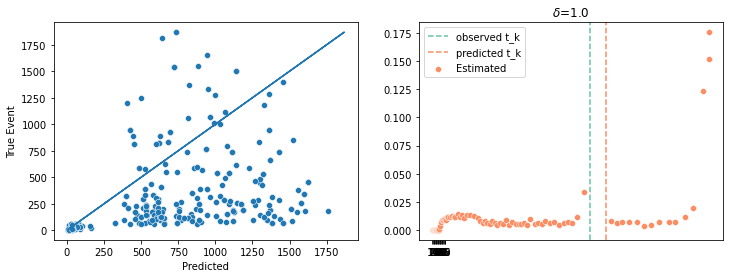

====> Train NLL: 2.782 	 Valid NLL: 2.663 CI: 0.859 event loss: 151991.022 	 censoring loss : 51838.775 	 Improved: *
epoch105


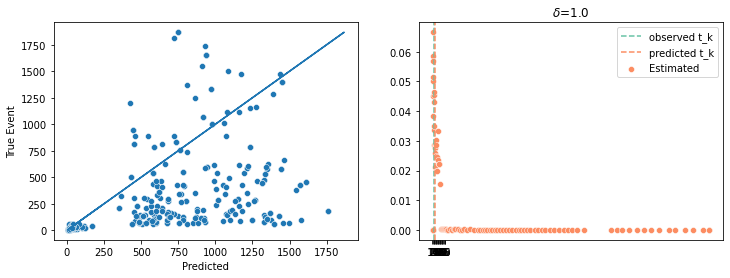

====> Train NLL: 2.789 	 Valid NLL: 2.659 CI: 0.859 event loss: 157971.530 	 censoring loss : 49181.785 	 Improved: *
epoch106
====> Train NLL: 2.775 	 Valid NLL: 2.658 CI: 0.857 event loss: 161394.369 	 censoring loss : 48804.135 	 Improved:  
epoch107
====> Train NLL: 2.781 	 Valid NLL: 2.656 CI: 0.858 event loss: 165138.588 	 censoring loss : 47417.340 	 Improved:  
epoch108


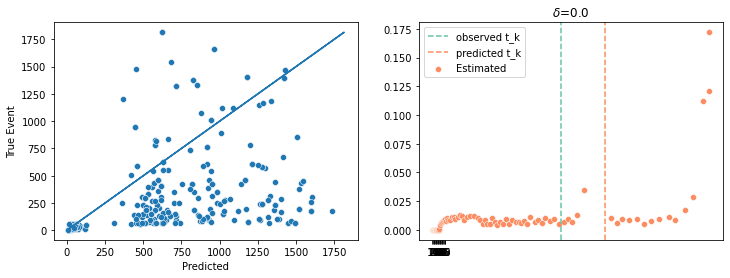

====> Train NLL: 2.780 	 Valid NLL: 2.656 CI: 0.859 event loss: 149253.738 	 censoring loss : 54354.969 	 Improved: *
epoch109
====> Train NLL: 2.760 	 Valid NLL: 2.649 CI: 0.859 event loss: 158129.290 	 censoring loss : 49995.958 	 Improved:  
epoch110


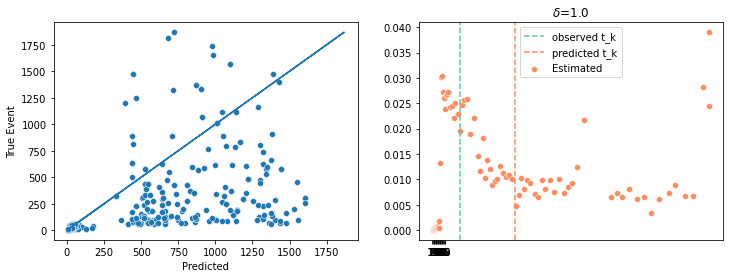

====> Train NLL: 2.768 	 Valid NLL: 2.647 CI: 0.860 event loss: 150313.746 	 censoring loss : 52544.018 	 Improved: *
epoch111
====> Train NLL: 2.767 	 Valid NLL: 2.646 CI: 0.859 event loss: 154942.183 	 censoring loss : 50792.288 	 Improved:  
epoch112
====> Train NLL: 2.769 	 Valid NLL: 2.648 CI: 0.858 event loss: 162715.044 	 censoring loss : 47464.103 	 Improved:  
epoch113
====> Train NLL: 2.761 	 Valid NLL: 2.644 CI: 0.859 event loss: 159015.409 	 censoring loss : 49836.388 	 Improved:  
epoch114


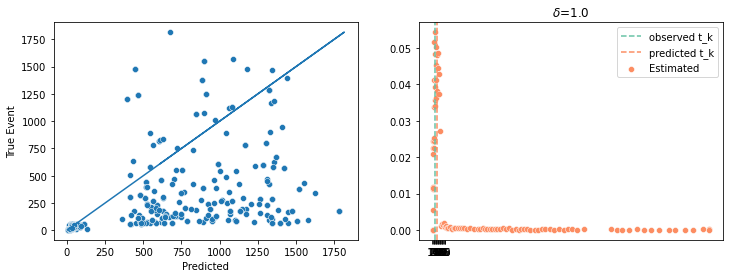

====> Train NLL: 2.764 	 Valid NLL: 2.636 CI: 0.861 event loss: 150930.715 	 censoring loss : 52522.141 	 Improved: *
epoch115
====> Train NLL: 2.755 	 Valid NLL: 2.639 CI: 0.861 event loss: 145376.350 	 censoring loss : 54835.218 	 Improved:  
epoch116
====> Train NLL: 2.750 	 Valid NLL: 2.636 CI: 0.860 event loss: 155771.188 	 censoring loss : 50063.409 	 Improved:  
epoch117
====> Train NLL: 2.748 	 Valid NLL: 2.634 CI: 0.860 event loss: 152993.618 	 censoring loss : 52860.319 	 Improved:  
epoch118
====> Train NLL: 2.742 	 Valid NLL: 2.629 CI: 0.860 event loss: 159075.586 	 censoring loss : 49190.975 	 Improved:  
epoch119
====> Train NLL: 2.746 	 Valid NLL: 2.628 CI: 0.861 event loss: 156285.255 	 censoring loss : 50677.079 	 Improved:  
epoch120
====> Train NLL: 2.743 	 Valid NLL: 2.631 CI: 0.859 event loss: 156650.007 	 censoring loss : 51581.826 	 Improved:  
epoch121
====> Train NLL: 2.747 	 Valid NLL: 2.622 CI: 0.861 event loss: 155686.550 	 censoring loss : 50529.868 	 Impro

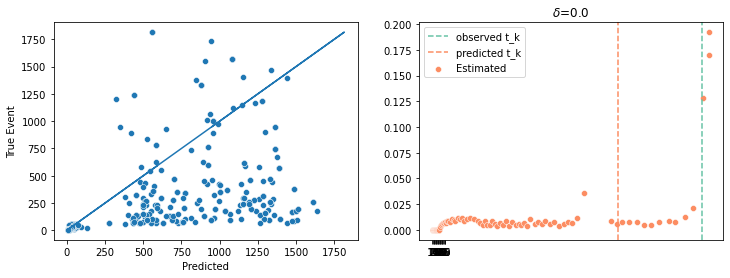

====> Train NLL: 2.750 	 Valid NLL: 2.624 CI: 0.860 event loss: 144946.013 	 censoring loss : 55628.608 	 Improved: *
epoch123


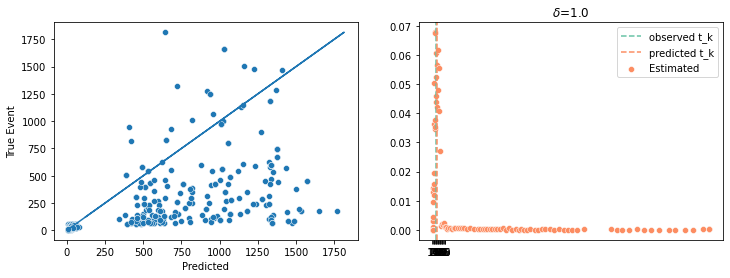

====> Train NLL: 2.727 	 Valid NLL: 2.621 CI: 0.861 event loss: 147967.974 	 censoring loss : 53666.954 	 Improved: *
epoch124
====> Train NLL: 2.742 	 Valid NLL: 2.622 CI: 0.860 event loss: 151376.001 	 censoring loss : 52248.290 	 Improved:  
epoch125
====> Train NLL: 2.722 	 Valid NLL: 2.617 CI: 0.860 event loss: 156972.255 	 censoring loss : 49550.317 	 Improved:  
epoch126
====> Train NLL: 2.726 	 Valid NLL: 2.618 CI: 0.861 event loss: 151860.907 	 censoring loss : 51767.031 	 Improved:  
epoch127


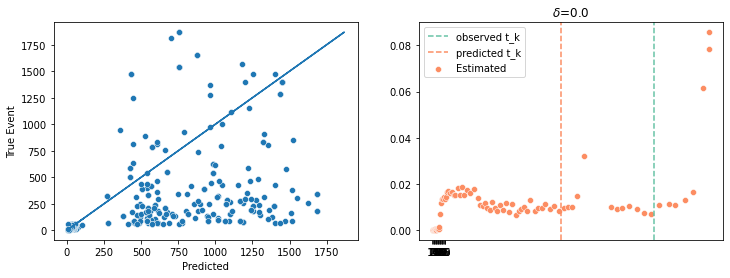

====> Train NLL: 2.727 	 Valid NLL: 2.610 CI: 0.861 event loss: 159398.804 	 censoring loss : 48766.090 	 Improved: *
epoch128
====> Train NLL: 2.718 	 Valid NLL: 2.611 CI: 0.860 event loss: 155705.947 	 censoring loss : 50606.919 	 Improved:  
epoch129
====> Train NLL: 2.729 	 Valid NLL: 2.614 CI: 0.861 event loss: 153673.621 	 censoring loss : 51928.754 	 Improved:  
epoch130
====> Train NLL: 2.724 	 Valid NLL: 2.611 CI: 0.861 event loss: 154923.740 	 censoring loss : 50289.503 	 Improved:  
epoch131


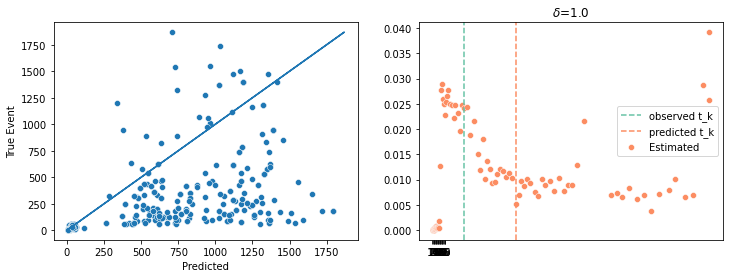

====> Train NLL: 2.716 	 Valid NLL: 2.607 CI: 0.861 event loss: 152272.295 	 censoring loss : 52297.348 	 Improved: *
epoch132


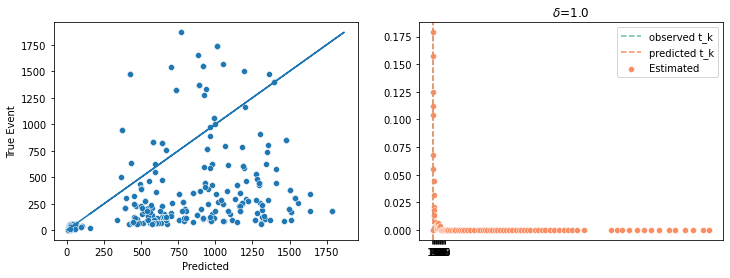

====> Train NLL: 2.714 	 Valid NLL: 2.604 CI: 0.862 event loss: 145511.710 	 censoring loss : 54308.401 	 Improved: *
epoch133
====> Train NLL: 2.714 	 Valid NLL: 2.603 CI: 0.861 event loss: 156676.162 	 censoring loss : 50611.972 	 Improved:  
epoch134
====> Train NLL: 2.705 	 Valid NLL: 2.607 CI: 0.860 event loss: 146215.358 	 censoring loss : 54166.119 	 Improved:  
epoch135
====> Train NLL: 2.713 	 Valid NLL: 2.603 CI: 0.861 event loss: 150377.187 	 censoring loss : 52858.750 	 Improved:  
epoch136
====> Train NLL: 2.712 	 Valid NLL: 2.599 CI: 0.861 event loss: 151214.592 	 censoring loss : 52468.998 	 Improved:  
epoch137


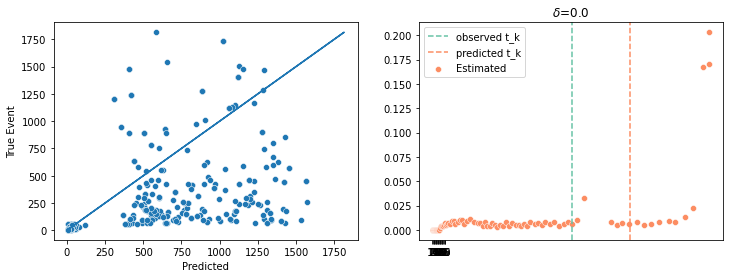

====> Train NLL: 2.702 	 Valid NLL: 2.600 CI: 0.861 event loss: 140758.863 	 censoring loss : 56916.836 	 Improved: *
epoch138
====> Train NLL: 2.708 	 Valid NLL: 2.596 CI: 0.861 event loss: 151289.067 	 censoring loss : 53350.463 	 Improved:  
epoch139


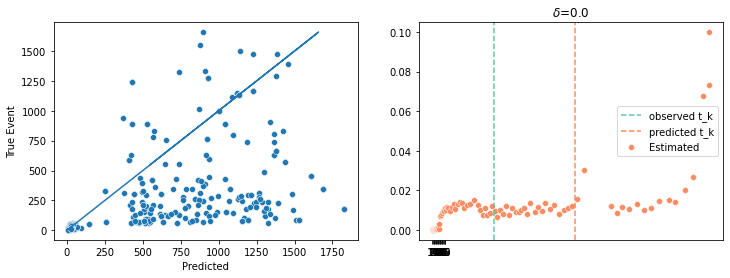

====> Train NLL: 2.705 	 Valid NLL: 2.591 CI: 0.862 event loss: 152833.249 	 censoring loss : 51319.255 	 Improved: *
epoch140
====> Train NLL: 2.700 	 Valid NLL: 2.595 CI: 0.861 event loss: 147777.042 	 censoring loss : 53914.435 	 Improved:  
epoch141
====> Train NLL: 2.712 	 Valid NLL: 2.593 CI: 0.861 event loss: 157268.938 	 censoring loss : 50774.463 	 Improved:  
epoch142
====> Train NLL: 2.707 	 Valid NLL: 2.592 CI: 0.862 event loss: 161824.143 	 censoring loss : 47682.706 	 Improved:  
epoch143


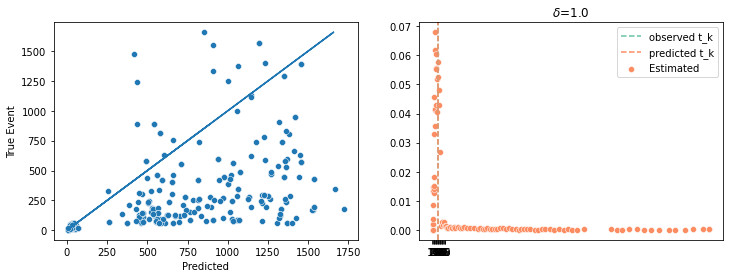

====> Train NLL: 2.700 	 Valid NLL: 2.585 CI: 0.862 event loss: 155469.805 	 censoring loss : 50589.160 	 Improved: *
epoch144
====> Train NLL: 2.699 	 Valid NLL: 2.583 CI: 0.862 event loss: 156106.817 	 censoring loss : 50950.515 	 Improved:  
epoch145


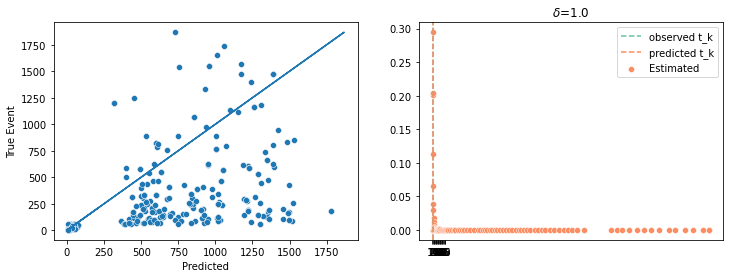

====> Train NLL: 2.695 	 Valid NLL: 2.582 CI: 0.863 event loss: 156570.435 	 censoring loss : 49994.501 	 Improved: *
epoch146
====> Train NLL: 2.698 	 Valid NLL: 2.588 CI: 0.862 event loss: 149013.490 	 censoring loss : 53686.585 	 Improved:  
epoch147


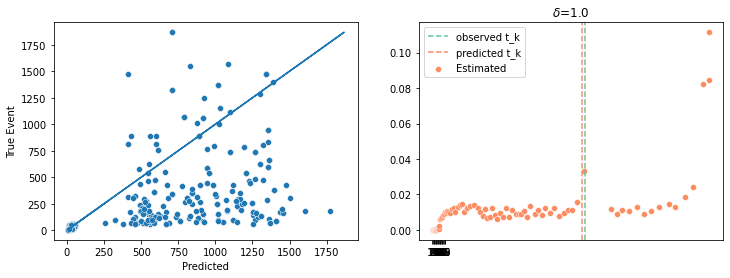

====> Train NLL: 2.678 	 Valid NLL: 2.586 CI: 0.863 event loss: 140507.266 	 censoring loss : 55198.164 	 Improved: *
epoch148


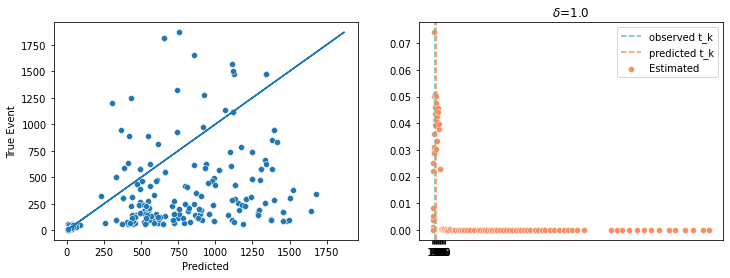

====> Train NLL: 2.698 	 Valid NLL: 2.584 CI: 0.864 event loss: 141127.698 	 censoring loss : 56355.154 	 Improved: *
epoch149
====> Train NLL: 2.700 	 Valid NLL: 2.582 CI: 0.862 event loss: 154191.357 	 censoring loss : 51266.821 	 Improved:  
epoch150
====> Train NLL: 2.684 	 Valid NLL: 2.582 CI: 0.863 event loss: 143498.355 	 censoring loss : 55693.746 	 Improved:  
epoch151
====> Train NLL: 2.681 	 Valid NLL: 2.583 CI: 0.861 event loss: 160360.523 	 censoring loss : 49640.553 	 Improved:  
epoch152
====> Train NLL: 2.682 	 Valid NLL: 2.578 CI: 0.862 event loss: 154505.318 	 censoring loss : 50588.914 	 Improved:  
epoch153
====> Train NLL: 2.679 	 Valid NLL: 2.578 CI: 0.862 event loss: 153428.302 	 censoring loss : 51561.897 	 Improved:  
epoch154
====> Train NLL: 2.679 	 Valid NLL: 2.581 CI: 0.862 event loss: 146261.542 	 censoring loss : 54981.255 	 Improved:  
epoch155
====> Train NLL: 2.668 	 Valid NLL: 2.571 CI: 0.863 event loss: 156108.773 	 censoring loss : 48885.199 	 Impro

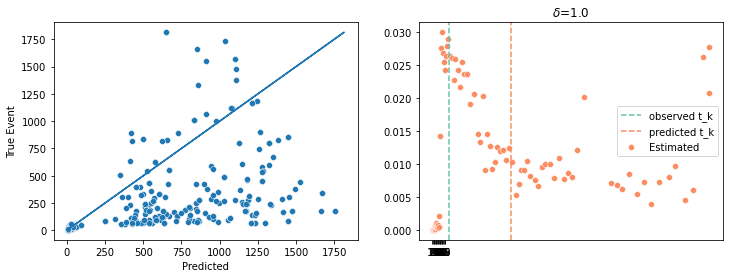

====> Train NLL: 2.672 	 Valid NLL: 2.569 CI: 0.864 event loss: 140335.541 	 censoring loss : 57174.213 	 Improved: *
epoch161
====> Train NLL: 2.678 	 Valid NLL: 2.569 CI: 0.863 event loss: 152196.018 	 censoring loss : 51796.023 	 Improved:  
epoch162
====> Train NLL: 2.660 	 Valid NLL: 2.573 CI: 0.861 event loss: 149071.123 	 censoring loss : 53139.723 	 Improved:  
epoch163
====> Train NLL: 2.659 	 Valid NLL: 2.562 CI: 0.862 event loss: 156019.745 	 censoring loss : 50265.276 	 Improved:  
epoch164
====> Train NLL: 2.664 	 Valid NLL: 2.565 CI: 0.863 event loss: 147035.361 	 censoring loss : 54386.886 	 Improved:  
epoch165
====> Train NLL: 2.654 	 Valid NLL: 2.561 CI: 0.864 event loss: 159814.856 	 censoring loss : 49553.603 	 Improved:  
epoch166
====> Train NLL: 2.653 	 Valid NLL: 2.565 CI: 0.863 event loss: 162266.878 	 censoring loss : 47260.145 	 Improved:  
epoch167


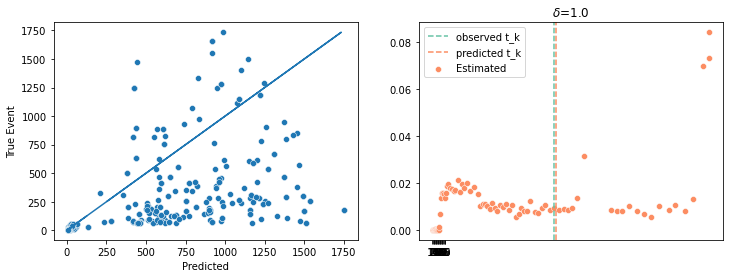

====> Train NLL: 2.664 	 Valid NLL: 2.555 CI: 0.864 event loss: 145697.387 	 censoring loss : 53554.154 	 Improved: *
epoch168
====> Train NLL: 2.648 	 Valid NLL: 2.552 CI: 0.864 event loss: 146187.924 	 censoring loss : 53962.447 	 Improved:  
epoch169
====> Train NLL: 2.655 	 Valid NLL: 2.554 CI: 0.864 event loss: 157824.632 	 censoring loss : 50040.143 	 Improved:  
epoch170


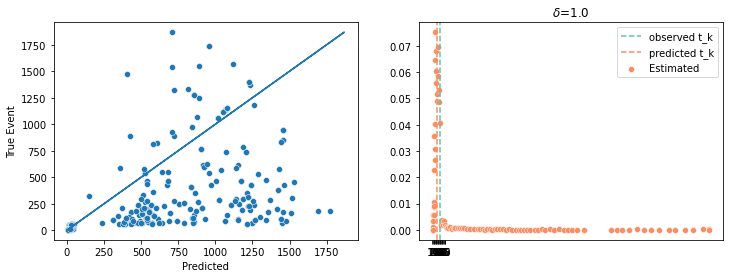

====> Train NLL: 2.650 	 Valid NLL: 2.553 CI: 0.864 event loss: 143001.612 	 censoring loss : 56156.340 	 Improved: *
epoch171
====> Train NLL: 2.661 	 Valid NLL: 2.554 CI: 0.863 event loss: 154800.082 	 censoring loss : 51041.698 	 Improved:  
epoch172
====> Train NLL: 2.656 	 Valid NLL: 2.548 CI: 0.864 event loss: 158080.884 	 censoring loss : 49600.957 	 Improved:  
epoch173
====> Train NLL: 2.646 	 Valid NLL: 2.555 CI: 0.863 event loss: 162864.784 	 censoring loss : 48189.883 	 Improved:  
epoch174
====> Train NLL: 2.651 	 Valid NLL: 2.550 CI: 0.863 event loss: 157249.691 	 censoring loss : 50592.746 	 Improved:  
epoch175
====> Train NLL: 2.654 	 Valid NLL: 2.554 CI: 0.863 event loss: 158174.907 	 censoring loss : 50235.245 	 Improved:  
epoch176
====> Train NLL: 2.637 	 Valid NLL: 2.550 CI: 0.863 event loss: 155928.091 	 censoring loss : 50247.282 	 Improved:  
epoch177
====> Train NLL: 2.642 	 Valid NLL: 2.548 CI: 0.863 event loss: 155605.776 	 censoring loss : 50149.418 	 Impro

In [23]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []
valid_lost_ctr_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
    clf.train()
    decoder.train()


    for i, (x, y, e, mask) in enumerate(pair1):
#         print(i)
        # training encoder and decoder
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
            
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        # when certain observation is missed, the corresponding mask is 0
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + args.pt_wt*loss_est

        # update parameters
        loss = surv_loss + args.ct_wt*loss_infoNCE
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += loss_infoNCE.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    clf.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_ct_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e, mask) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        
        del mask_new
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        # save one subject for plotting
        subj = np.random.choice(len(e))
        subj_res = t_wa_hat[subj].squeeze().detach().cpu().item(), p_raw[subj].detach().cpu().numpy(), y[subj].detach().cpu().item(), e[subj].detach().cpu().item()
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + args.pt_wt*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        valid_ct_loss += loss_infoNCE.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze().detach().cpu().numpy())
        valid_t.append(y.squeeze().detach().cpu().numpy())
        valid_e.append(e.squeeze().detach().cpu().numpy())
        del t_wa_hat, y, e, loss, loss_NLL, loss_est, eloss, closs, loss_infoNCE
    
    # try scheduler
    emb_scheduler.step(valid_NLL_loss)
    clf_scheduler.step(valid_ct_loss)
    dec_scheduler.step(valid_est_loss)
        
    # concatenate all the validation results
    valid_e = np.concatenate(valid_e)
    valid_t = np.concatenate(valid_t)
    valid_pred_t = np.concatenate(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t, torch_object=False)[0]
    
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    valid_lost_ctr_hist.append(valid_ct_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1


    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
        torch.save(clf.module.state_dict(), clf_path)
        torch.save(decoder.module.state_dict(), dec_path)
        torch.save(attention.module.state_dict(), att_path)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        r_idx = np.random.choice(np.where(valid_e==1)[0],500)
        sns.scatterplot(valid_pred_t[r_idx], valid_t[r_idx])
        plt.plot(valid_t[r_idx], valid_t[r_idx])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        
        plt.subplot(1, 2, 2)
        t_hat, p_raw, true_t, event_type = subj_res
        plt.axvline(true_t,linestyle='--',color=emp_color,label='observed t_k')
        plt.axvline(t_hat,linestyle='--',color=pred_color,label='predicted t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw, label='Estimated', color=pred_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(event_type))
        plt.show()


        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    del valid_t, valid_e, valid_pred_t
    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

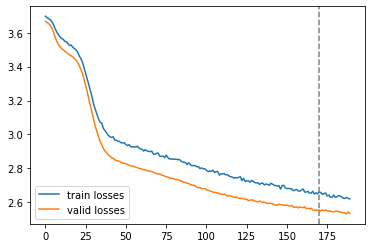

In [34]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.axvline(best_epoch, color='gray',linestyle='--')
plt.legend()

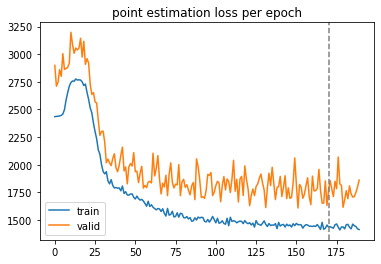

In [48]:
plt.plot(train_loss_est_hist,label="train")
plt.plot(valid_loss_est_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('point estimation loss per epoch')

plt.legend()

NameError: name 'valid_lost_ctr_hist' is not defined

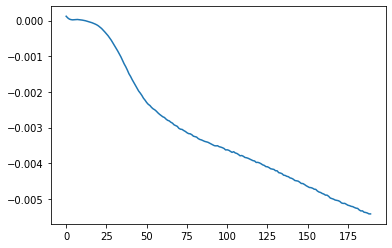

In [49]:
plt.plot(train_lost_ctr_hist,label="train")
plt.plot(valid_lost_ctr_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('Contrastive loss per epoch')

plt.legend()

In [32]:

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)


embedding.load_state_dict(torch.load(emb_path))
attention.load_state_dict(torch.load(att_path))
clf.load_state_dict(torch.load(clf_path))
decoder.load_state_dict(torch.load(dec_path))


# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)



In [ ]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

Text(0.5, 1.0, 'AGE embedding')

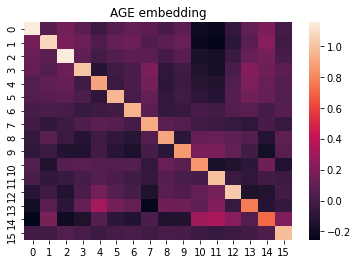

In [33]:
ax = sns.heatmap(embedding.x_emb_landmarks['age'].detach().cpu().numpy())
plt.title('AGE embedding')

### Evaluating performance on testing dataset

In [39]:
from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN


embedding.eval()
decoder.eval()
clf.eval()
attention.eval()


test_e_loss = test_c_loss= 0
test_pred_t = []
test_pred_raw = []
test_t = []
test_e = []
# test_x = []
for i, (x, y, e, mask) in enumerate(t_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)
    mask = mask.to(device)
    
    x_emb, var_list = embedding(x.float())

    # re-indexing mask
    reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list]).to(device)
    mask_new = torch.index_select(mask, 1, reindex)
    del mask
    mask_attn = torch.ones(len(mask_new), ncov, ncov).to(device)-torch.diag(torch.ones(ncov)).unsqueeze(0).repeat(len(mask_new),1,1).to(device)+torch.vstack([torch.diag(mask_new[idx]).unsqueeze(0) for idx in range(len(mask_new))])
    del mask_new
    z, attn_score = attention(x_emb, mask = mask_attn)
    del mask_attn
 
    p_raw = decoder(clf.module.enc(z))

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + args.pt_wt*loss_est
    
#     test_x.append(x)
    test_pred_raw.append(p_raw.detach().cpu())
    test_pred_t.append(t_wa_hat.squeeze().detach().cpu())
    test_t.append(y.squeeze().detach().cpu())
    test_e.append(e.squeeze().detach().cpu())
    test_e_loss += eloss.item()

    test_c_loss += closs.item()

print(test_e_loss/len(test['e']))


139092.22717377552


Text(0.5, 1.0, 'Attention Score')

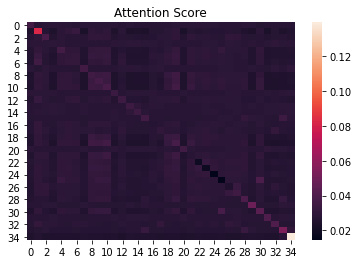

In [40]:
attn_score_avg = attn_score.mean(axis=0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')

In [37]:
# def NLL_reg(p_raw, y, e, tt, collapsed=True):
#     # using likelihood to regularize the performance
#     y_cat = batch_t_categorize(torch.tensor(y).to('cpu'), torch.tensor(e).to('cpu'), tt.to('cpu'))
#     #         keep_idx = torch.where(y <= t_max)[0]
    
#     if collapsed:
#         y_loglikeli = -((p_raw*y_cat).sum(axis=1)+1e-6).log().sum()
#     else:
#         y_loglikeli = -((p_raw*y_cat).sum(axis=1)+1e-6).log()
#     #  -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
    
#     return y_loglikeli

tensor(2.5957)

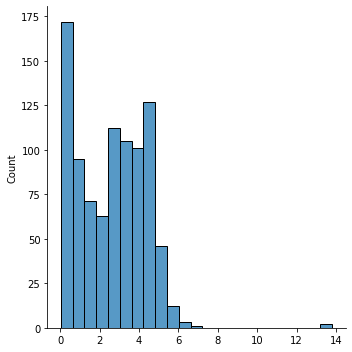

In [42]:
test_pred_raw = torch.cat(test_pred_raw)
test_e = torch.cat(test_e)
test_t = torch.cat(test_t)
test_pred_t = torch.cat(test_pred_t)
# test_x = torch.cat(test_x)
test_likeli = NLL_reg(test_pred_raw, test_t, test_e, tt, collapsed=False)
sns.displot(test_likeli.cpu().detach().numpy())
test_likeli.mean()


In [43]:
def I_Ctd_DLN(t, e, test_pred_prob, tt, i,j):
#     x_i = x[i]
#     x_j = x[j]
    t_true_i = t[i]
    t_i_idx = torch.where(batch_t_categorize(t[i].reshape([1,1]), e[i].reshape([1,1]), tt)[-1]==1)[0]
    sum_idx = torch.cat([torch.ones(t_i_idx), torch.zeros(len(tt)-t_i_idx)])
#     print(test_pred_prob[i], sum_idx)
    F_i = torch.dot(test_pred_prob[i].squeeze(), sum_idx)
    F_j = torch.dot(test_pred_prob[j].squeeze(), sum_idx)
    return(1*(F_i > F_j).cpu().detach().item())
    # return (log_S_i, log_S_j)

def pair_Ctd_DLN(t, e, test_pred_prob, tt):
    j_pool = []
    while len(j_pool)==0:
        subj_i = np.random.choice(torch.where(e==1)[0],1)
        j_pool = torch.where(t>t[subj_i])[0]
        
    subj_j = np.random.choice(torch.where(t>t[subj_i])[0],1)
        
    return(I_Ctd_DLN(t, e, test_pred_prob, tt, subj_i,subj_j))

In [44]:
ACSurv_Ctd = [pair_Ctd_DLN(test_t.to('cpu'), test_e.to('cpu'), test_pred_raw.to('cpu'), tt.to('cpu')) for k in np.arange(10000)]
np.mean(ACSurv_Ctd)

0.7943

0.8610764655089705

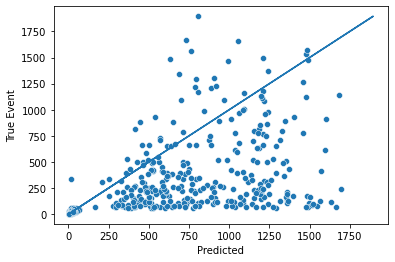

In [46]:

plt.figure()

sns.scatterplot(test_pred_t[test_e==1].cpu().detach().numpy().squeeze(), test_t[test_e==1].cpu())
plt.plot(test_t[test_e==1].cpu(), test_t[test_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

# plt.xlim(0,200)
# plt.ylim(0,200)

test_CI = get_CI_raw(test_e, test_t, test_pred_t, torch_object=True)[0]
test_CI


In [28]:
# single head attention
# https://github.com/QiangAIResearcher/sahp_repo/blob/master/models/attention/single.py

import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def forward(self, query, key, value, mask=None, dropout=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn
    
    
class MultiHeadedAttention(nn.Module):
    """
    Take in models size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model, bias=True) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model, bias=True)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # the same mask applies to all heads
            # unsqueeze Returns a new tensor with a dimension of size one
            # inserted at the specified position.
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention.forward(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

## define MLP network

In [52]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_clf(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_clf, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [53]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']
ncov = X.shape[1]
covList = np.arange(ncov)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

trainData = SimpleDataset(X, t, train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(test['x'], test['t'], test['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

NameError: name 'train' is not defined

In [51]:
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP_cts(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_only.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_only.pt'

print(encoder, decoder)

NameError: name 'X' is not defined

Text(0, 0.5, 'True Event')

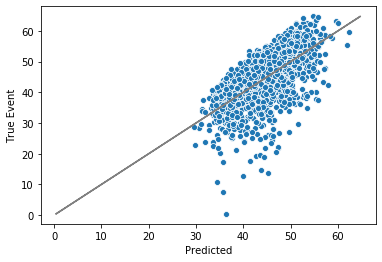

In [136]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))



Text(0, 0.5, 'True Event')

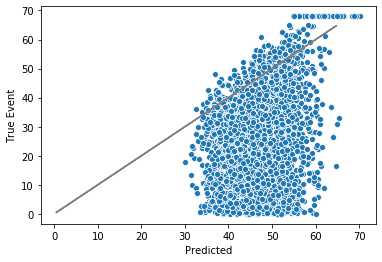

In [137]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')


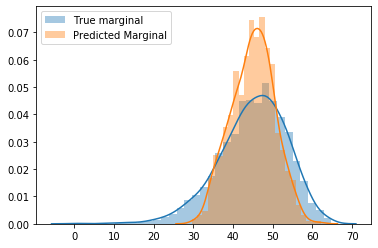

In [138]:
sns.distplot(y[e==1], label = 'True marginal')
sns.distplot(t_hat[e==1].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

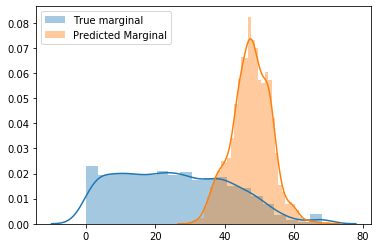

In [140]:
sns.distplot(y[e==0], label = 'True marginal')
sns.distplot(t_hat[e==0].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

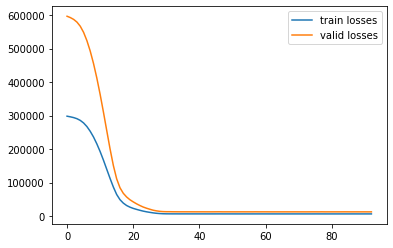

In [141]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [73]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
t = decoder(z)

calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)


NameError: name 'calculate_KS_Div' is not defined

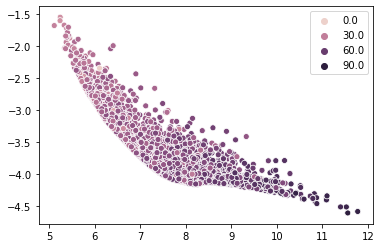

In [142]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [62]:
x[0,:]

tensor([ 34.9360, 760.7106,   3.0000,  48.0000], device='cuda:1')

/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


(tensor(55.4096), tensor(1))

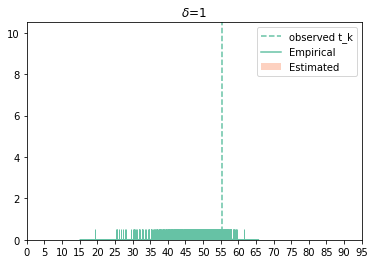

In [156]:
y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
# y_cat = batch_t_categorize(y, e, tt)
x = (torch.tensor(test['x']).to(device).float()-mean)/std

subj = 6
x_new = x[subj,:].expand(100,-1)
z = encoder(x_new.to(device).float())
t_hat = decoder(z)


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')
sns.distplot(t_hat.detach().numpy(), label='Estimated', color=pred_color)
# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]



## select pairs with data loader

In [159]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

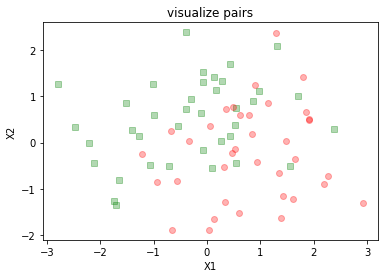

In [160]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,ncov].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,ncov].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## Define the network

In [177]:
# if retrain encoder, decoder
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)



hidden_layer=[128,128]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*zdim, output_size = 1, h_dim=hidden_layer)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# define weight
ctr_wt = 1
clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf_'+str(ctr_wt)+'.pt'

enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_'+str(ctr_wt)+'.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_'+str(ctr_wt)+'.pt'
print(encoder, decoder)
print(clf)


EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [178]:
def single_patient_true_surv_cox_gompertz(covariates, beta_linear = np.array([0.15,0.001]),lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    St = np.exp(-(lambda_/alpha_)*(np.exp(alpha_*tt)-1)*np.exp(np.dot(X,beta_linear)))
    return({"St": St})

# KS divergence
def KS_D(F1, F2, tt):
    diff_list = np.abs((np.ones(len(tt))-F1)-(np.ones(len(tt))-F2))
    return(tt[np.argmax(diff_list)], np.max(diff_list), diff_list)

def calculate_KS_Div(x, p_raw, tt):
    KS_list = []
    for subj in np.arange(p_raw.shape[0]):
        true_St=single_patient_true_surv_cox_gompertz(covariates=x[subj,:].numpy(), tt=tt)['St']
        St = 1-np.cumsum(p_raw[subj,:].detach().numpy())
        diff_t, diff_D, diff_list = KS_D(St, true_St, tt)
        KS_list.append(diff_D)

    return np.mean(KS_list)

epoch1
====> Train Loss: 598019.7891 	 NLL: 598019.0964 	 contrastive loss: 0.6927
====> Valid NLL loss: 597951.3697 	Improved: *
epoch2
====> Train Loss: 594047.0299 	 NLL: 594046.3373 	 contrastive loss: 0.6926
====> Valid NLL loss: 593967.2894 	Improved: *
epoch3
====> Train Loss: 589606.2762 	 NLL: 589605.5859 	 contrastive loss: 0.6904
====> Valid NLL loss: 588863.4839 	Improved: *
epoch4
====> Train Loss: 583396.0191 	 NLL: 583395.3324 	 contrastive loss: 0.6866
====> Valid NLL loss: 581354.4926 	Improved: *
epoch5
====> Train Loss: 574136.1998 	 NLL: 574135.5143 	 contrastive loss: 0.6854
====> Valid NLL loss: 570171.2735 	Improved: *
epoch6
====> Train Loss: 560883.1960 	 NLL: 560882.5164 	 contrastive loss: 0.6796
====> Valid NLL loss: 554962.1832 	Improved: *
epoch7
====> Train Loss: 543442.8007 	 NLL: 543442.1210 	 contrastive loss: 0.6797
====> Valid NLL loss: 535245.0540 	Improved: *
epoch8
====> Train Loss: 521175.5906 	 NLL: 521174.9125 	 contrastive loss: 0.6781
====> V

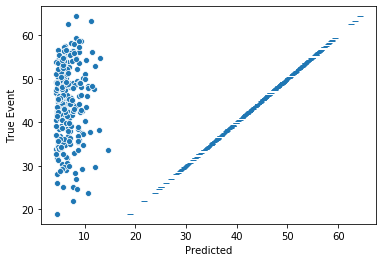

====> Valid NLL loss: 443585.2255 	Improved: *
epoch11
====> Train Loss: 420164.6468 	 NLL: 420163.9572 	 contrastive loss: 0.6896
====> Valid NLL loss: 401766.9092 	Improved: *
epoch12
====> Train Loss: 374934.3770 	 NLL: 374933.6866 	 contrastive loss: 0.6904
====> Valid NLL loss: 354130.7078 	Improved: *
epoch13
====> Train Loss: 324830.3126 	 NLL: 324829.6137 	 contrastive loss: 0.6989
====> Valid NLL loss: 301821.9226 	Improved: *
epoch14
====> Train Loss: 270542.3757 	 NLL: 270541.6795 	 contrastive loss: 0.6961
====> Valid NLL loss: 246452.3501 	Improved: *
epoch15
====> Train Loss: 214540.7464 	 NLL: 214540.0440 	 contrastive loss: 0.7024
====> Valid NLL loss: 189844.9166 	Improved: *
epoch16
====> Train Loss: 159721.3941 	 NLL: 159720.7027 	 contrastive loss: 0.6914
====> Valid NLL loss: 136861.0703 	Improved: *
epoch17
====> Train Loss: 111336.2215 	 NLL: 111335.5248 	 contrastive loss: 0.6967
====> Valid NLL loss: 92870.5845 	Improved: *
epoch18
====> Train Loss: 75672.8004 

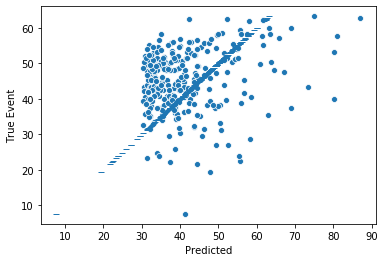

====> Valid NLL loss: 42338.0001 	Improved: *
epoch21
====> Train Loss: 40003.0587 	 NLL: 40002.4144 	 contrastive loss: 0.6443
====> Valid NLL loss: 35756.5713 	Improved: *
epoch22
====> Train Loss: 34202.7668 	 NLL: 34202.1356 	 contrastive loss: 0.6312
====> Valid NLL loss: 30925.7458 	Improved: *
epoch23
====> Train Loss: 29414.3942 	 NLL: 29413.7891 	 contrastive loss: 0.6052
====> Valid NLL loss: 26442.2598 	Improved: *
epoch24
====> Train Loss: 25343.0441 	 NLL: 25342.4597 	 contrastive loss: 0.5843
====> Valid NLL loss: 22554.2147 	Improved: *
epoch25
====> Train Loss: 21688.4007 	 NLL: 21687.8271 	 contrastive loss: 0.5736
====> Valid NLL loss: 19419.3841 	Improved: *
epoch26
====> Train Loss: 18724.4195 	 NLL: 18723.8701 	 contrastive loss: 0.5494
====> Valid NLL loss: 16684.5260 	Improved: *
epoch27
====> Train Loss: 16354.2513 	 NLL: 16353.7213 	 contrastive loss: 0.5300
====> Valid NLL loss: 14846.8080 	Improved: *
epoch28
====> Train Loss: 14719.5111 	 NLL: 14718.9951 	 c

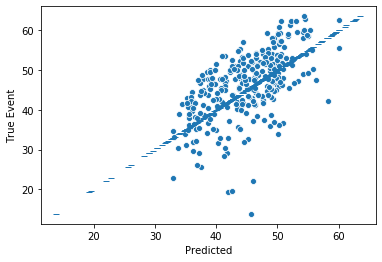

====> Valid NLL loss: 13177.1507 	Improved: *
epoch31
====> Train Loss: 13505.7222 	 NLL: 13505.2616 	 contrastive loss: 0.4606
====> Valid NLL loss: 13094.6500 	Improved: *
epoch32
====> Train Loss: 13543.8405 	 NLL: 13543.3762 	 contrastive loss: 0.4643
====> Valid NLL loss: 13019.2507 	Improved: *
epoch33
====> Train Loss: 13423.6661 	 NLL: 13423.2327 	 contrastive loss: 0.4335
====> Valid NLL loss: 12920.3799 	Improved: *
epoch34
====> Train Loss: 13384.7042 	 NLL: 13384.2586 	 contrastive loss: 0.4455
====> Valid NLL loss: 12925.0167 	Improved:  
epoch35
====> Train Loss: 13342.0673 	 NLL: 13341.6349 	 contrastive loss: 0.4324
====> Valid NLL loss: 12906.3424 	Improved: *
epoch36
====> Train Loss: 13323.9790 	 NLL: 13323.5160 	 contrastive loss: 0.4630
====> Valid NLL loss: 12832.8989 	Improved: *
epoch37
====> Train Loss: 13274.1347 	 NLL: 13273.6813 	 contrastive loss: 0.4534
====> Valid NLL loss: 12865.5729 	Improved:  
epoch38
====> Train Loss: 13272.0883 	 NLL: 13271.6599 	 c

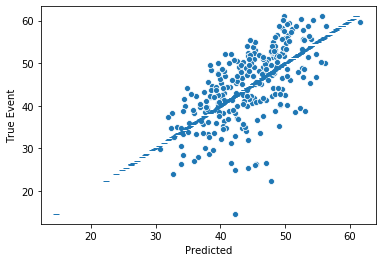

====> Valid NLL loss: 12859.1196 	Improved:  
epoch41
====> Train Loss: 13220.9757 	 NLL: 13220.5458 	 contrastive loss: 0.4299
====> Valid NLL loss: 12951.9346 	Improved:  
epoch42
====> Train Loss: 13225.6749 	 NLL: 13225.2266 	 contrastive loss: 0.4483
====> Valid NLL loss: 12818.2862 	Improved: *
epoch43
====> Train Loss: 13279.9613 	 NLL: 13279.5194 	 contrastive loss: 0.4420
====> Valid NLL loss: 12762.1877 	Improved: *
epoch44
====> Train Loss: 13176.2616 	 NLL: 13175.8109 	 contrastive loss: 0.4507
====> Valid NLL loss: 12773.9132 	Improved:  
epoch45
====> Train Loss: 13170.0187 	 NLL: 13169.5752 	 contrastive loss: 0.4436
====> Valid NLL loss: 12824.4867 	Improved:  
epoch46
====> Train Loss: 13168.9664 	 NLL: 13168.5430 	 contrastive loss: 0.4234
====> Valid NLL loss: 12765.5885 	Improved:  
epoch47
====> Train Loss: 13148.9148 	 NLL: 13148.4844 	 contrastive loss: 0.4304
====> Valid NLL loss: 12794.9337 	Improved:  
epoch48
====> Train Loss: 13143.3875 	 NLL: 13142.9708 	 c

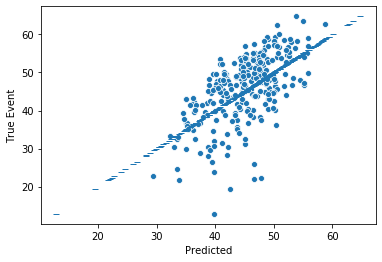

====> Valid NLL loss: 12835.9686 	Improved:  
epoch51
====> Train Loss: 13138.1506 	 NLL: 13137.7252 	 contrastive loss: 0.4254
====> Valid NLL loss: 12725.9454 	Improved: *
epoch52
====> Train Loss: 13111.8537 	 NLL: 13111.4002 	 contrastive loss: 0.4535
====> Valid NLL loss: 12722.2071 	Improved: *
epoch53
====> Train Loss: 13111.7381 	 NLL: 13111.2930 	 contrastive loss: 0.4451
====> Valid NLL loss: 12729.1283 	Improved:  
epoch54
====> Train Loss: 13132.6492 	 NLL: 13132.2242 	 contrastive loss: 0.4250
====> Valid NLL loss: 12771.4539 	Improved:  
epoch55
====> Train Loss: 13107.8243 	 NLL: 13107.3813 	 contrastive loss: 0.4430
====> Valid NLL loss: 12721.1712 	Improved: *
epoch56
====> Train Loss: 13135.3618 	 NLL: 13134.9311 	 contrastive loss: 0.4307
====> Valid NLL loss: 12738.0711 	Improved:  
epoch57
====> Train Loss: 13138.6031 	 NLL: 13138.1878 	 contrastive loss: 0.4153
====> Valid NLL loss: 12754.5380 	Improved:  
epoch58
====> Train Loss: 13107.0987 	 NLL: 13106.6747 	 c

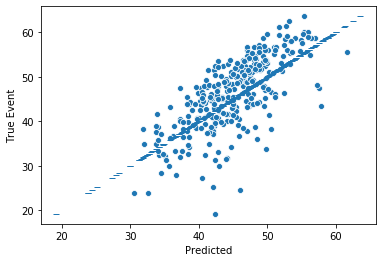

====> Valid NLL loss: 12722.0240 	Improved:  
epoch61
====> Train Loss: 13150.5374 	 NLL: 13150.1199 	 contrastive loss: 0.4175
====> Valid NLL loss: 12868.2655 	Improved:  
epoch62
====> Train Loss: 13128.3587 	 NLL: 13127.9362 	 contrastive loss: 0.4225
====> Valid NLL loss: 12835.4688 	Improved:  
epoch63
====> Train Loss: 13156.6407 	 NLL: 13156.1849 	 contrastive loss: 0.4558
====> Valid NLL loss: 12775.3208 	Improved:  
epoch64
====> Train Loss: 13116.1991 	 NLL: 13115.7611 	 contrastive loss: 0.4380
====> Valid NLL loss: 12756.9529 	Improved:  
epoch65
====> Train Loss: 13071.6303 	 NLL: 13071.1878 	 contrastive loss: 0.4425
====> Valid NLL loss: 12811.6858 	Improved:  
epoch66
====> Train Loss: 13142.0779 	 NLL: 13141.6618 	 contrastive loss: 0.4161
====> Valid NLL loss: 12745.9660 	Improved:  
epoch67
====> Train Loss: 13093.7162 	 NLL: 13093.2862 	 contrastive loss: 0.4299
====> Valid NLL loss: 12748.4260 	Improved:  
epoch68
====> Train Loss: 13091.8983 	 NLL: 13091.4484 	 c

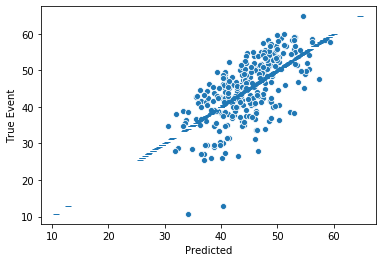

====> Valid NLL loss: 12731.0398 	Improved:  
epoch71
====> Train Loss: 13077.5687 	 NLL: 13077.1287 	 contrastive loss: 0.4400
====> Valid NLL loss: 12737.7116 	Improved:  
epoch72
====> Train Loss: 13076.2160 	 NLL: 13075.7758 	 contrastive loss: 0.4402
====> Valid NLL loss: 12770.8685 	Improved:  
epoch73
====> Train Loss: 13073.7884 	 NLL: 13073.3466 	 contrastive loss: 0.4418
====> Valid NLL loss: 12727.8262 	Improved:  
epoch74
====> Train Loss: 13077.3815 	 NLL: 13076.9625 	 contrastive loss: 0.4190
====> Valid NLL loss: 12765.2236 	Improved:  
epoch75
====> Train Loss: 13087.9939 	 NLL: 13087.5644 	 contrastive loss: 0.4295
====> Valid NLL loss: 12810.7804 	Improved:  
epoch76
====> Train Loss: 13104.9230 	 NLL: 13104.4807 	 contrastive loss: 0.4422
====> Valid NLL loss: 12771.3601 	Improved:  
epoch77
====> Train Loss: 13127.6548 	 NLL: 13127.2184 	 contrastive loss: 0.4364
====> Valid NLL loss: 12727.9086 	Improved:  
epoch78
====> Train Loss: 13111.4183 	 NLL: 13110.9807 	 c

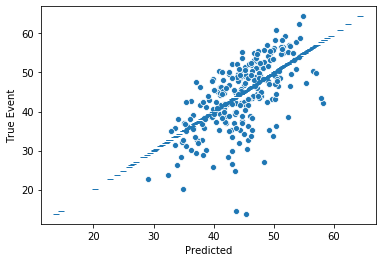

====> Valid NLL loss: 12724.3933 	Improved:  
epoch81
====> Train Loss: 13061.8460 	 NLL: 13061.3974 	 contrastive loss: 0.4486
====> Valid NLL loss: 12731.6868 	Improved:  
epoch82
====> Train Loss: 13056.2522 	 NLL: 13055.8364 	 contrastive loss: 0.4159
====> Valid NLL loss: 12730.0449 	Improved:  
epoch83
====> Train Loss: 13086.2539 	 NLL: 13085.8219 	 contrastive loss: 0.4320
====> Valid NLL loss: 12722.6596 	Improved:  
epoch84
====> Train Loss: 13057.1914 	 NLL: 13056.7831 	 contrastive loss: 0.4083
====> Valid NLL loss: 12759.3006 	Improved:  
epoch85
====> Train Loss: 13045.6148 	 NLL: 13045.1647 	 contrastive loss: 0.4502
====> Valid NLL loss: 12743.8962 	Improved:  
epoch86
====> Train Loss: 13049.2473 	 NLL: 13048.8090 	 contrastive loss: 0.4383
====> Valid NLL loss: 12722.0114 	Improved:  
epoch87
====> Train Loss: 13060.7456 	 NLL: 13060.3080 	 contrastive loss: 0.4376
====> Valid NLL loss: 12770.5181 	Improved:  
epoch88
====> Train Loss: 13063.7471 	 NLL: 13063.3050 	 c

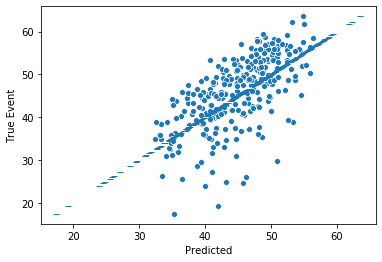

====> Valid NLL loss: 12769.4634 	Improved:  
epoch91
====> Train Loss: 13047.0298 	 NLL: 13046.5940 	 contrastive loss: 0.4358
====> Valid NLL loss: 12713.6341 	Improved: *
epoch92
====> Train Loss: 13052.9826 	 NLL: 13052.5488 	 contrastive loss: 0.4339
====> Valid NLL loss: 12711.4939 	Improved: *
epoch93
====> Train Loss: 13053.4693 	 NLL: 13053.0642 	 contrastive loss: 0.4051
====> Valid NLL loss: 12713.3494 	Improved:  
epoch94
====> Train Loss: 13044.3930 	 NLL: 13043.9609 	 contrastive loss: 0.4321
====> Valid NLL loss: 12812.6387 	Improved:  
epoch95
====> Train Loss: 13067.8431 	 NLL: 13067.4030 	 contrastive loss: 0.4401
====> Valid NLL loss: 12730.2543 	Improved:  
epoch96
====> Train Loss: 13060.8590 	 NLL: 13060.4204 	 contrastive loss: 0.4385
====> Valid NLL loss: 12716.9933 	Improved:  
epoch97
====> Train Loss: 13056.2686 	 NLL: 13055.8173 	 contrastive loss: 0.4512
====> Valid NLL loss: 12733.1271 	Improved:  
epoch98
====> Train Loss: 13063.3422 	 NLL: 13062.9008 	 c

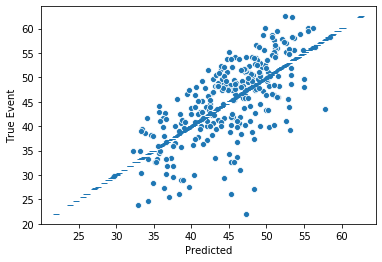

====> Valid NLL loss: 12733.7970 	Improved:  
epoch101
====> Train Loss: 13052.4548 	 NLL: 13052.0503 	 contrastive loss: 0.4045
====> Valid NLL loss: 12714.1316 	Improved:  
epoch102
====> Train Loss: 13061.8613 	 NLL: 13061.4265 	 contrastive loss: 0.4348
====> Valid NLL loss: 12719.1677 	Improved:  
epoch103
====> Train Loss: 13039.1456 	 NLL: 13038.7035 	 contrastive loss: 0.4420
====> Valid NLL loss: 12781.1753 	Improved:  
epoch104
====> Train Loss: 13048.1370 	 NLL: 13047.6974 	 contrastive loss: 0.4397
====> Valid NLL loss: 12748.8731 	Improved:  
epoch105
====> Train Loss: 13049.8632 	 NLL: 13049.4425 	 contrastive loss: 0.4207
====> Valid NLL loss: 12746.8474 	Improved:  
epoch106
====> Train Loss: 13049.5661 	 NLL: 13049.1342 	 contrastive loss: 0.4319
====> Valid NLL loss: 12719.6019 	Improved:  
epoch107
====> Train Loss: 13087.0904 	 NLL: 13086.6635 	 contrastive loss: 0.4269
====> Valid NLL loss: 12740.0475 	Improved:  
epoch108
====> Train Loss: 13051.0923 	 NLL: 13050.

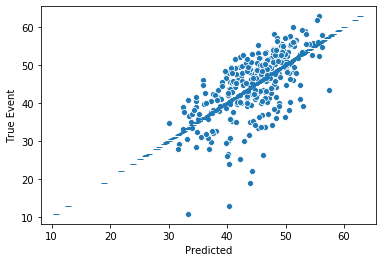

====> Valid NLL loss: 12729.3689 	Improved:  
epoch111
====> Train Loss: 13035.5777 	 NLL: 13035.1185 	 contrastive loss: 0.4592
====> Valid NLL loss: 12740.4515 	Improved:  
epoch112
====> Train Loss: 13060.3620 	 NLL: 13059.9474 	 contrastive loss: 0.4146
====> Valid NLL loss: 12729.8343 	Improved:  
epoch113
====> Train Loss: 13088.5834 	 NLL: 13088.1448 	 contrastive loss: 0.4386
====> Valid NLL loss: 13125.3151 	Improved:  
epoch114
====> Train Loss: 13135.6957 	 NLL: 13135.2858 	 contrastive loss: 0.4099
====> Valid NLL loss: 12805.1062 	Improved:  
epoch115
====> Train Loss: 13060.0642 	 NLL: 13059.6227 	 contrastive loss: 0.4415
====> Valid NLL loss: 12755.2794 	Improved:  
epoch116
====> Train Loss: 13051.0426 	 NLL: 13050.5870 	 contrastive loss: 0.4556
====> Valid NLL loss: 12731.2745 	Improved:  
epoch117
====> Train Loss: 13027.8330 	 NLL: 13027.3883 	 contrastive loss: 0.4447
====> Valid NLL loss: 12757.4770 	Improved:  
epoch118
====> Train Loss: 13051.4616 	 NLL: 13051.

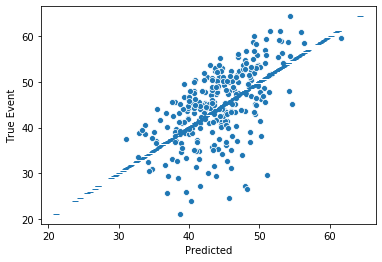

====> Valid NLL loss: 12738.1924 	Improved:  
epoch121
====> Train Loss: 13024.7337 	 NLL: 13024.2969 	 contrastive loss: 0.4368
====> Valid NLL loss: 12762.4697 	Improved:  
epoch122
====> Train Loss: 13036.5841 	 NLL: 13036.1480 	 contrastive loss: 0.4360
====> Valid NLL loss: 12733.9582 	Improved:  
epoch123
====> Train Loss: 13024.5396 	 NLL: 13024.1286 	 contrastive loss: 0.4110
====> Valid NLL loss: 12761.9589 	Improved:  
epoch124
====> Train Loss: 13021.1104 	 NLL: 13020.6761 	 contrastive loss: 0.4343
====> Valid NLL loss: 12748.3884 	Improved:  
epoch125
====> Train Loss: 13022.3729 	 NLL: 13021.9593 	 contrastive loss: 0.4136
====> Valid NLL loss: 12756.8110 	Improved:  
epoch126
====> Train Loss: 13015.0091 	 NLL: 13014.5807 	 contrastive loss: 0.4284
====> Valid NLL loss: 12719.7755 	Improved:  
epoch127
====> Train Loss: 13048.8858 	 NLL: 13048.4436 	 contrastive loss: 0.4422
====> Valid NLL loss: 12731.9616 	Improved:  
epoch128
====> Train Loss: 13041.4858 	 NLL: 13041.

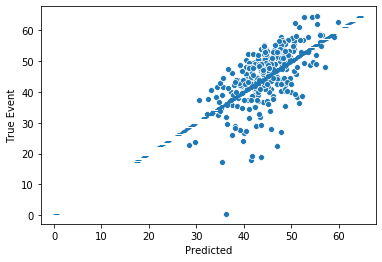

====> Valid NLL loss: 12784.7861 	Improved:  
epoch131
====> Train Loss: 13067.9203 	 NLL: 13067.4851 	 contrastive loss: 0.4352
====> Valid NLL loss: 12814.3798 	Improved:  
epoch132
====> Train Loss: 13030.2880 	 NLL: 13029.8742 	 contrastive loss: 0.4138
====> Valid NLL loss: 12788.0919 	Improved:  
epoch133
====> Train Loss: 13038.3311 	 NLL: 13037.8872 	 contrastive loss: 0.4439
====> Valid NLL loss: 12793.5724 	Improved:  
epoch134
====> Train Loss: 13038.9755 	 NLL: 13038.5322 	 contrastive loss: 0.4433
====> Valid NLL loss: 12725.0740 	Improved:  
epoch135
====> Train Loss: 13028.4768 	 NLL: 13028.0335 	 contrastive loss: 0.4433
====> Valid NLL loss: 12747.7600 	Improved:  
epoch136
====> Train Loss: 13008.5013 	 NLL: 13008.0740 	 contrastive loss: 0.4273
====> Valid NLL loss: 12725.5353 	Improved:  
epoch137
====> Train Loss: 13032.9575 	 NLL: 13032.5341 	 contrastive loss: 0.4235
====> Valid NLL loss: 12781.3488 	Improved:  
epoch138
====> Train Loss: 13040.7918 	 NLL: 13040.

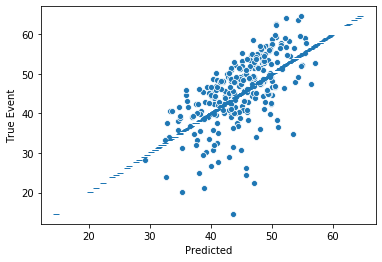

====> Valid NLL loss: 12747.5087 	Improved:  
epoch141
====> Train Loss: 13036.5761 	 NLL: 13036.1351 	 contrastive loss: 0.4410
====> Valid NLL loss: 12747.5475 	Improved:  
epoch142
====> Train Loss: 13012.4228 	 NLL: 13012.0163 	 contrastive loss: 0.4066
====> Valid NLL loss: 12706.6968 	Improved: *
epoch143
====> Train Loss: 13020.8392 	 NLL: 13020.4082 	 contrastive loss: 0.4310
====> Valid NLL loss: 12737.4249 	Improved:  
epoch144
====> Train Loss: 13008.8322 	 NLL: 13008.4056 	 contrastive loss: 0.4266
====> Valid NLL loss: 12711.0038 	Improved:  
epoch145
====> Train Loss: 13015.3056 	 NLL: 13014.8569 	 contrastive loss: 0.4486
====> Valid NLL loss: 12715.6097 	Improved:  
epoch146
====> Train Loss: 13018.3110 	 NLL: 13017.8974 	 contrastive loss: 0.4136
====> Valid NLL loss: 12727.4561 	Improved:  
epoch147
====> Train Loss: 13030.0922 	 NLL: 13029.6383 	 contrastive loss: 0.4539
====> Valid NLL loss: 12740.4881 	Improved:  
epoch148
====> Train Loss: 13026.2466 	 NLL: 13025.

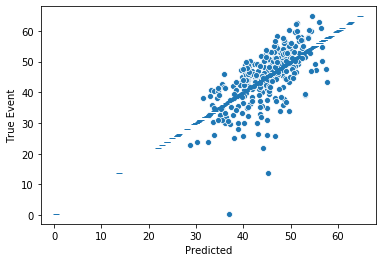

====> Valid NLL loss: 12739.2495 	Improved:  
epoch151
====> Train Loss: 13009.1714 	 NLL: 13008.7278 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.6999 	Improved:  
epoch152
====> Train Loss: 13060.1642 	 NLL: 13059.7434 	 contrastive loss: 0.4208
====> Valid NLL loss: 12724.9632 	Improved:  
epoch153
====> Train Loss: 13043.2361 	 NLL: 13042.8127 	 contrastive loss: 0.4234
====> Valid NLL loss: 12878.1238 	Improved:  
epoch154
====> Train Loss: 13038.3472 	 NLL: 13037.8841 	 contrastive loss: 0.4631
====> Valid NLL loss: 12736.6392 	Improved:  
epoch155
====> Train Loss: 13017.7028 	 NLL: 13017.2534 	 contrastive loss: 0.4494
====> Valid NLL loss: 12838.8231 	Improved:  
epoch156
====> Train Loss: 13043.3878 	 NLL: 13042.9857 	 contrastive loss: 0.4022
====> Valid NLL loss: 12762.7838 	Improved:  
epoch157
====> Train Loss: 13026.9848 	 NLL: 13026.5405 	 contrastive loss: 0.4443
====> Valid NLL loss: 12785.0023 	Improved:  
epoch158
====> Train Loss: 12988.4405 	 NLL: 12988.

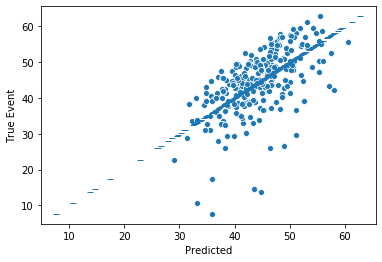

====> Valid NLL loss: 12765.7623 	Improved:  
epoch161
====> Train Loss: 13013.8832 	 NLL: 13013.4626 	 contrastive loss: 0.4206
====> Valid NLL loss: 12757.2912 	Improved:  
epoch162
====> Train Loss: 13026.2607 	 NLL: 13025.8136 	 contrastive loss: 0.4471
====> Valid NLL loss: 12738.8841 	Improved:  
epoch163
====> Train Loss: 13058.5776 	 NLL: 13058.1477 	 contrastive loss: 0.4299
====> Valid NLL loss: 12731.0131 	Improved:  
epoch164
====> Train Loss: 13007.3353 	 NLL: 13006.8815 	 contrastive loss: 0.4538
====> Valid NLL loss: 12741.7628 	Improved:  
epoch165
====> Train Loss: 13021.3738 	 NLL: 13020.9298 	 contrastive loss: 0.4441
====> Valid NLL loss: 12733.1938 	Improved:  
epoch166
====> Train Loss: 13027.9780 	 NLL: 13027.5494 	 contrastive loss: 0.4286
====> Valid NLL loss: 12720.6022 	Improved:  
epoch167
====> Train Loss: 13004.0276 	 NLL: 13003.5837 	 contrastive loss: 0.4439
====> Valid NLL loss: 12743.5851 	Improved:  
epoch168
====> Train Loss: 13005.4663 	 NLL: 13005.

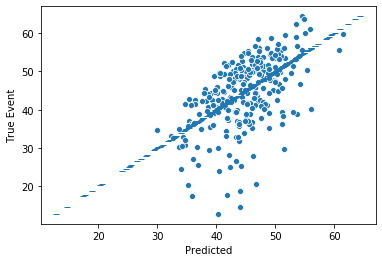

====> Valid NLL loss: 12713.8450 	Improved:  
epoch171
====> Train Loss: 13000.1278 	 NLL: 12999.7087 	 contrastive loss: 0.4192
====> Valid NLL loss: 12710.7473 	Improved:  
epoch172
====> Train Loss: 13013.5941 	 NLL: 13013.1637 	 contrastive loss: 0.4304
====> Valid NLL loss: 12810.1296 	Improved:  
epoch173
====> Train Loss: 13042.4473 	 NLL: 13041.9987 	 contrastive loss: 0.4487
====> Valid NLL loss: 12745.7766 	Improved:  
epoch174
====> Train Loss: 13021.0746 	 NLL: 13020.6147 	 contrastive loss: 0.4599
====> Valid NLL loss: 12714.2188 	Improved:  
epoch175
====> Train Loss: 13013.7596 	 NLL: 13013.3285 	 contrastive loss: 0.4311
====> Valid NLL loss: 12722.9236 	Improved:  
epoch176
====> Train Loss: 12984.9184 	 NLL: 12984.4757 	 contrastive loss: 0.4427
====> Valid NLL loss: 12804.7836 	Improved:  
epoch177
====> Train Loss: 13002.6678 	 NLL: 13002.2197 	 contrastive loss: 0.4481
====> Valid NLL loss: 12744.5712 	Improved:  
epoch178
====> Train Loss: 13009.8444 	 NLL: 13009.

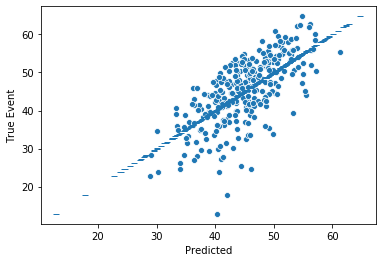

====> Valid NLL loss: 12734.3433 	Improved:  
epoch181
====> Train Loss: 13011.0712 	 NLL: 13010.6276 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.3336 	Improved:  
epoch182
====> Train Loss: 13037.0578 	 NLL: 13036.6320 	 contrastive loss: 0.4258
====> Valid NLL loss: 12747.2819 	Improved:  
epoch183
====> Train Loss: 12997.5006 	 NLL: 12997.0799 	 contrastive loss: 0.4207
====> Valid NLL loss: 12714.1267 	Improved:  
epoch184
====> Train Loss: 13018.0572 	 NLL: 13017.6178 	 contrastive loss: 0.4393
====> Valid NLL loss: 12744.8746 	Improved:  
epoch185
====> Train Loss: 13009.0862 	 NLL: 13008.6630 	 contrastive loss: 0.4232
====> Valid NLL loss: 12757.7515 	Improved:  
epoch186
====> Train Loss: 12998.8919 	 NLL: 12998.4601 	 contrastive loss: 0.4317
====> Valid NLL loss: 12741.2308 	Improved:  
epoch187
====> Train Loss: 12994.5166 	 NLL: 12994.0951 	 contrastive loss: 0.4215
====> Valid NLL loss: 12772.4112 	Improved:  
epoch188
====> Train Loss: 13004.3899 	 NLL: 13003.

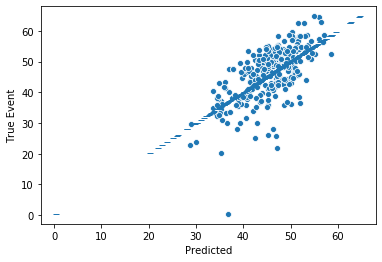

====> Valid NLL loss: 12744.9768 	Improved:  
epoch191
====> Train Loss: 13014.8920 	 NLL: 13014.4679 	 contrastive loss: 0.4241
====> Valid NLL loss: 12722.2676 	Improved:  
epoch192
====> Train Loss: 13007.6557 	 NLL: 13007.2138 	 contrastive loss: 0.4419
====> Valid NLL loss: 12865.7948 	Improved:  
Model stopped due to early stopping


In [179]:
best_valid_loss = np.inf
best_epoch = 0
# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))

train_loss_hist = []
train_rec_hist = []
train_ctr_hist = []

valid_loss_hist = []

ctr_learning = True
for epoch in range(1, epochs + 1):


    train_loss = 0
    rec_loss = 0
    ctr_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "

    
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2])
        e = torch.cat([e1,e2])
                
        if not ctr_learning:
            ctr_wt = 0
            
        clf.train()
        encoder.train()
        decoder.train()
        z = encoder(x)
        # exclude right censored subjects when training decoder
#             p_raw = decoder(z)

#             y_cat = batch_t_categorize(y, e, tt)
#             keep_idx = np.arange(len(e))

#             y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        rec_loss_ = closs + eloss


        # contrastive learning step
        delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        keep_idx_1 = torch.where(delete_loc==0)[0]
        keep_idx_2 = keep_idx_1+len(e1)

        batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

        batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss = rec_loss_ + ctr_wt*contrastive_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)

        train_loss += loss.item()
        rec_loss += rec_loss_.item()
        ctr_loss += contrastive_loss.item()

        opt_enc.step()  
        opt_dec.step()  
        opt_clf.step()          

        
    train_loss = train_loss/(i+1)
    rec_loss = rec_loss/(i+1) 
    ctr_loss = ctr_loss/(i+1)  

    print('====> Train Loss: {:.4f} \t NLL: {:.4f} \t contrastive loss: {:.4f}'.format(train_loss, rec_loss, ctr_loss))
    
    encoder.eval()
    decoder.eval()
    clf.eval()
    
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

        valid_loss_ = eloss.item()

        valid_loss += valid_loss_


    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    train_rec_hist.append(rec_loss)
    train_ctr_hist.append(ctr_loss)
    valid_loss_hist.append(valid_loss)
    
    if epoch % 10 == 0:
        
        sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
        plt.plot(y[e==1], y[e==1])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
#         plt.xlim(min(y), max(y))
#         plt.ylim(min(y), max(y))
        
#         subj = np.random.choice(len(e))
#         plt.figure()

#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

#         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
                
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()

    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid NLL loss: {:.4f} \tImproved: {}'.format(valid_loss, improved_str))

#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    if (epoch - best_epoch >=50):
        print('Model stopped due to early stopping')
        break        

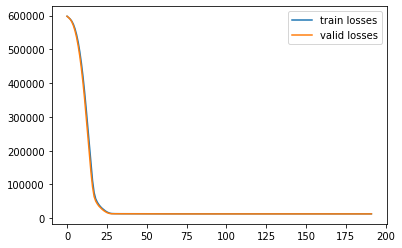

In [180]:
plt.plot(train_rec_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
# stop_ctr = train_ctr_hist.index(0)
# plt.axvline(stop_ctr,linestyle='--',color=emp_color,label='stop \ncontrastive \nlearning')

plt.legend()

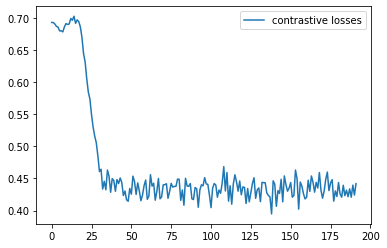

In [181]:
plt.plot(train_ctr_hist,label="contrastive losses")
plt.legend()

In [182]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))
for i, (x, y, e) in enumerate(pair1):
    break
enc_path, dec_path

('/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/enc_1.pt',
 '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/dec_1.pt')

Text(0, 0.5, 'True Event')

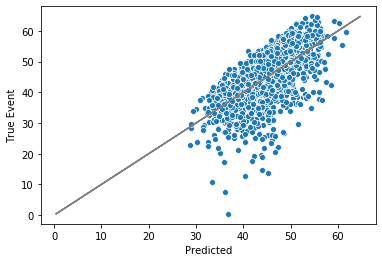

In [183]:
encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))

Text(0, 0.5, 'True Event')

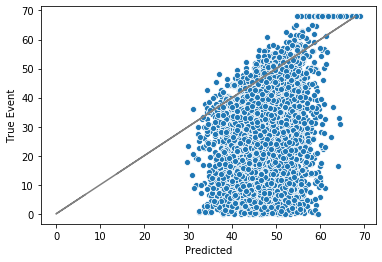

In [186]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==0], y[e==0], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')


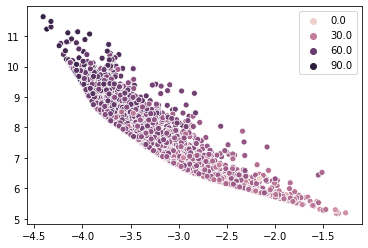

In [185]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [820]:
# torch.where(e==1),
np.where(test['t']>t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

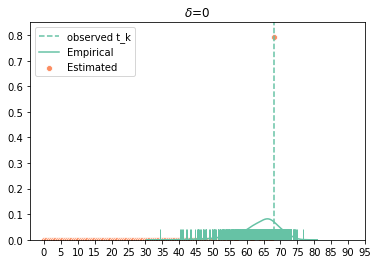

In [825]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 4511


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]

# y_cat = batch_t_categorize(y, e, tt)

# subj = 331
# x = x.to(device).float()
# z = encoder(x)
# p_raw = decoder(z)
# plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
# true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
# sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
# plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

# plt.legend(loc='upper right')
# plt.title(r'$\delta$='+str(e[subj].item()))
# y[subj], e[subj]

In [431]:
e.float().mean()

tensor(0.2660)

In [46]:
np.arange(0, 70, step=5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

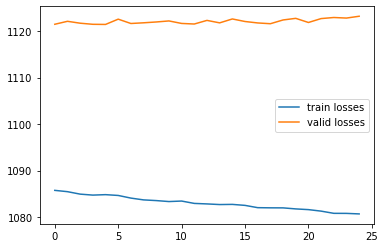

In [396]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

true      pred  dataPair1  dataPair2
0   1.0  0.744528  25.781141  43.624172
1   1.0  0.744528  15.027925  21.310776
2   1.0  0.744528  20.414146  30.561441
3   1.0  0.744528  22.647816  30.683744
4   0.0  0.742164  15.022316  19.621126

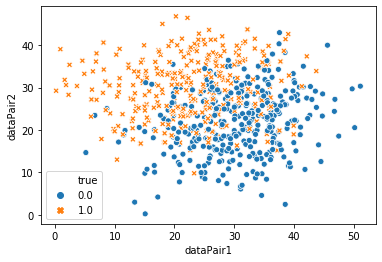

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


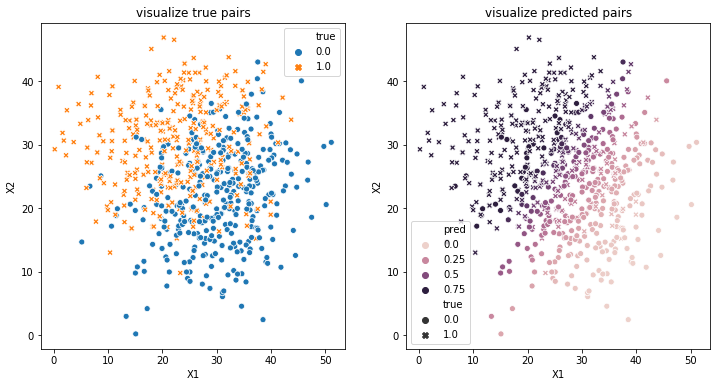

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [422]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




RuntimeError: Error(s) in loading state_dict for SimpleMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([32, 2]) from checkpoint, the shape in current model is torch.Size([32, 4]).

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

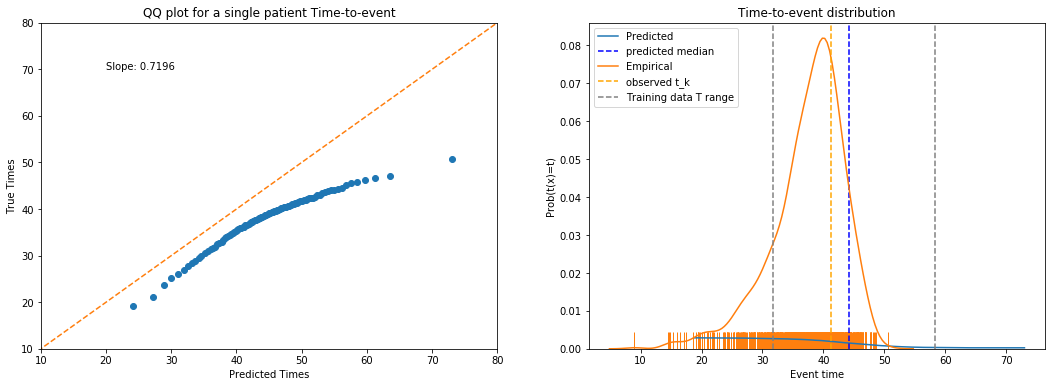

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

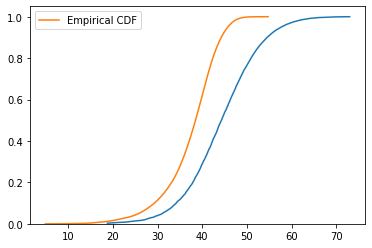

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
